In [1]:
## v11.7 changed the 'loom time' parameter to be from -600 to +1300 (this is mainly for the autoloom data)
# v11.8 changed the threshold perc_pulses (cut-off continuous or delayed) to 15%
# changed the minumum Hz parameter (also for c/d cut-off) to 0.2Hz considering the whole bout, not just the beginning half of the bout

In [1]:
import glob
from matplotlib import cm
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg, NavigationToolbar2Tk)
import math
import numpy as np
import os
import pandas as pd
import pathlib
import re
import seaborn as sns
from scipy.interpolate import interp1d
import scipy.signal as scisig
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.metrics import r2_score
import scikit_posthocs as sp
import time 
import tkinter as tk
from tkinter import filedialog as fd
from tqdm.notebook import tqdm, trange
import warnings


warnings.filterwarnings("ignore")

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)
%matplotlib inline

In [3]:
frame_rate_pg = 120
frame_rate_hc = 50

peak_prom_all = 4
added = 0.1
#to define continuous and delayed pulsing
perc_pulses = 15 #%
time_frame = 50 #%
minimum_hz = 0.2 #below this we will consider the bout to be delayed even if there are more than the cut-off spikes in the first 50%

exp_end = 614 #s

walking_thresh = 0.02

pre_loom = 600
post_loom = 40000
times = np.arange(-pre_loom,post_loom)
print(times.shape)

stim_len = 10.7 #i.e. 10 seconds after the end of the loom

save_location = "C:/Users/Anna/Dropbox/muscles_paper/5_mar2024/graphs/social/"

(40600,)


In [4]:
def peaks_troughs2(data,times,peak_prom = 1,trough_ord = 20,smoothed = 'no',graph = 'yes',title = "",threshold = 0):
    
    if smoothed  == 'yes': #can smooth the data with different amounts
        timez = np.hstack([times,times[-1]+1])
        timez = np.array(timez)
        dataz = data
        dataz = dataz.rolling(2,center = True).mean()
        dataz = dataz.append(pd.Series([dataz.min()]))
        peaks_smooth = scisig.find_peaks(dataz,height = 0, prominence = peak_prom)
        peaks_locs_smooth = peaks_smooth[0]
        peaks_heights_smooth = peaks_smooth[1]["peak_heights"]
        
        if threshold > 0:
            locations_smooth = peaks_heights_smooth > threshold
            peaks_locs_smooth = peaks_locs_smooth[locations_smooth]
            peaks_heights_smooth = peaks_heights_smooth[locations_smooth]
        
        troughs_smooth = scisig.argrelmin(dataz.values,order = trough_ord)
        scatterz2_height_smooth = [dataz.values[x] for x in troughs_smooth[0]]
        scatterz_smooth = [times[x] for x in peaks_locs_smooth]
        scatterz2_smooth = [times[x] for x in troughs_smooth[0]]
        

    #data=data-data.min()
    #data=data/data.max()    
    times = np.hstack([times,times[-1]+1])
    times = np.array(times)
    data = data.append(pd.Series([data.min()]))
    peaks = scisig.find_peaks(data,height = 0, prominence = peak_prom)
    peaks_locs = peaks[0]
    peaks_heights = peaks[1]["peak_heights"]
    if threshold > 0:
        locations = peaks_heights > threshold
        peaks_locs = peaks_locs[locations]
        peaks_heights = peaks_heights[locations]
    
    troughs = scisig.argrelmin(data.values,order = trough_ord)
    scatterz2_height = [data.values[x] for x in troughs[0]]
    scatterz = [times[x] for x in peaks_locs]
    scatterz2 = [times[x] for x in troughs[0]]
    
        
    if graph == 'yes':
        fig2,ax2 = plt.subplots(figsize=(14,3))
        
        plt.plot(times,data,label = "raw",color='k',zorder = 1)
        plt.scatter(scatterz,peaks_heights,color='b',s=100,zorder = 2,alpha = 0.7,label = "Peak raw")
        plt.scatter(scatterz2,scatterz2_height,color = [0.2,0.7,0.7])
        if smoothed == 'yes':
            plt.plot(times,dataz,label = "smoothed",color = [0.5,0,0],zorder = 3)
            plt.scatter(scatterz_smooth,peaks_heights_smooth,color=[1,0.4,0.4],s = 80,zorder = 4,alpha = 0.7,label = "Peak smoothed")
            plt.scatter(scatterz2_smooth,scatterz2_height_smooth,color = [1,0.7,0.7])

        plt.title(title,fontsize=20)
        plt.xlabel("Frame")
        plt.ylabel("Normalised fluorescence")
        plt.legend()
        #plt.xlim([3000,5000])
        
        
    if smoothed == 'yes':
        if graph == 'yes':
            return dataz,peaks_locs_smooth,peaks_heights_smooth,fig2
        else:
            return dataz,peaks_locs_smooth,peaks_heights_smooth
    else:
        return data.iloc,peaks_locs,peaks_heights


def binned_heatmap_pixchange(data_all,pix_change_all,baseline = 300,bins = 0.5, sort=True,max_val = 500,figx = 15,figy=8,save=""):
    reshaped = pd.DataFrame()
    for name in list(pix_change_all):
        #print(name)
        bin_size = int(frame_rate_pg*bins)
        no_bins = int(pix_change_all.shape[0]//bin_size)
        dataz = pix_change_all[name].iloc[:no_bins*bin_size]
        dat_resh = dataz.values.reshape([no_bins,bin_size])
        meanz = dat_resh.mean(axis=1)
        reshaped[name] = meanz
    
    #print(no_bins)
    looming = np.zeros((no_bins,len(list(pix_change_all))))
    looming[:] = np.nan
    
    #print(looming.shape)
    
    if sort == True:
        sort_arg = np.array(reshaped.iloc[int(baseline/bins):].mean(axis=0).argsort())
        print(sort_arg)
        
    else:
        sort_arg = np.arange(reshaped.shape[1])
    
    #for gist in [list(pix_change_all)[i] for i in sort_arg]:
    #    print(gist[40:])
    sorted_reshaped = reshaped.iloc[:,sort_arg]
    
    for i,file in enumerate(data_all.Filename.unique()):
        
        dataz = data_all.query("Filename == @file").iloc[:sorted_reshaped.shape[0]*bin_size].query("event == 'Loom'")
        #print(dataz)
        normalised = np.array(round(dataz.Orig_index/(bins*frame_rate_pg)).astype(int))
        
        #print(normalised)
        
        looming[normalised,i] = 100
        looming[normalised-1,i] = 100 #these are to make the loom line thicker so it's easier to see
        looming[normalised+1,i] = 100
        looming[0,0] = 0
        sorted_loomed = pd.DataFrame(looming).iloc[:,sort_arg]
    
    fig, axs = plt.subplots(figsize=(figx, figy))
    axs.xaxis.set_visible(False)
    axs.yaxis.set_visible(False)
    sns.heatmap(np.transpose(sorted_reshaped), cmap='viridis', vmin=0, vmax=max_val, cbar=True, linewidths=0)
    sns.heatmap(np.transpose(sorted_loomed), cmap="bwr" , cbar=False, linewidths=0)
    plt.xlim([0,1200])
    
    if len(save) > 0:
        fig.savefig(save)



def binned_heatmap_pixchange_pulse(data_all,pix_change_all,baseline = 300,bins = 0.3, sort=True,max_val = 500,figx = 15,figy=8,save=""):
    reshaped = pd.DataFrame()
    for name in list(pix_change_all):
        bin_size = int(frame_rate_pg*bins)
        no_bins = int(pix_change_all.shape[0]//bin_size)
        dataz = pix_change_all[name].iloc[:no_bins*bin_size]
        dat_resh = dataz.values.reshape([no_bins,bin_size])
        meanz = dat_resh.mean(axis=1)
        reshaped[name] = meanz
    
    looming = np.zeros((no_bins,len(list(pix_change_all))))
    looming[:] = np.nan
    
    pulsing = np.zeros((no_bins,len(list(pix_change_all))))
    pulsing[:] = np.nan
    
    if sort == True:
        sort_arg = np.array(reshaped.iloc[int(baseline/bins):].mean(axis=0).argsort())
        print(sort_arg)
        
    else:
        sort_arg = np.arange(reshaped.shape[1])
    
    for gist in [list(pix_change_all)[i] for i in sort_arg]:
        print(gist[80:])
    sorted_reshaped = reshaped.iloc[:,sort_arg]
    
    for i,file in enumerate(data_all.Filename.unique()):
        
        dataz = data_all.query("Filename == @file").iloc[:sorted_reshaped.shape[0]*bin_size].query("event == 'Loom'")
        normalised = np.array(round(dataz.Orig_index/(bins*frame_rate_pg)).astype(int))
        
        dataz_pulse = data_all.query("Filename == @file").iloc[:sorted_reshaped.shape[0]*bin_size].query("pulse == 1")
        normalised_pulse = np.array(round(dataz_pulse.Orig_index/(bins*frame_rate_pg)).astype(int))
        
        
        pulsing[normalised_pulse,i] = 100
        sorted_pulse = pd.DataFrame(pulsing).iloc[:,sort_arg]
        
        looming[normalised,i] = 100
        looming[normalised-1,i] = 100 #these are to make the loom line thicker so it's easier to see
        looming[normalised+1,i] = 100
        looming[0,0] = 0
        sorted_loomed = pd.DataFrame(looming).iloc[:,sort_arg]
    
    fig, axs = plt.subplots(figsize=(figx, figy))
    axs.xaxis.set_visible(False)
    axs.yaxis.set_visible(False)
    sns.heatmap(np.transpose(sorted_reshaped), cmap='viridis', vmin=0, vmax=max_val, cbar=True, linewidths=0)
    sns.heatmap(np.transpose(sorted_pulse),cmap = "gist_yarg",cbar = False,linewidths = 0) #gist_yarg
    sns.heatmap(np.transpose(sorted_loomed), cmap="bwr" , cbar=False, linewidths=0)
    
    lim = 300*(1/bins)
    plt.xlim([lim-10,sorted_loomed.shape[0]])
    
    if len(save) > 0:
        fig.savefig(save)
        
        dat_pulse = data_all.query("Filename == @file").iloc[:sorted_reshaped.shape[0]*bin_size].query("pulse == 1")
        norm_pulse = normalised = np.array(round(dataz.index.to_series()/(bins*frame_rate_pg)).astype(int))



def reshaped(pix_change_all,bin_size):
    no_bins = int(pix_change_all.shape[0]//bin_size)
    #print(no_bins)
    dataz = pix_change_all.iloc[:no_bins*bin_size]
    dat_resh = dataz.values.reshape([no_bins,bin_size])
    #print(dat_resh)
    meanz = dat_resh.mean(axis=1)
    #print(meanz)
    return(meanz)


def melted_reshaped(pix_change,condition):
    pix_change_reshape = pd.DataFrame()
    for name, values in pix_change.iteritems():
        means = reshaped(values,240)
        #print(means.shape)
        pix_change_reshape[name] = means
    #print(pix_change_reshape.shape)
    melted = pd.melt(pix_change_reshape,var_name = "filename",ignore_index = False)
    #print(melted)
    melted["condition"] = condition
    return melted


def length_of_pauses(data_all,last_start = 615):
    pauses_all = pd.DataFrame(columns = ["Filename","Time_start","Pause_length"])
    for file in data_all.Filename.unique():
        #print(file)
        dataz_diff = data_all.query("Filename == @file and immobility == 1").normed_time.diff()
        dataz_diff = dataz_diff.reset_index()
        dataz_diff = dataz_diff.rename(columns={dataz_diff.columns[0]: "frame" })
        #print(dataz_diff)
        if dataz_diff.shape[0] > 0:
            pause_start = np.array(dataz_diff[dataz_diff.normed_time > 0.025].index)
            pause_start = np.hstack([dataz_diff.index[0],pause_start])
            pause_end = pause_start[1:]-1
            pause_end = np.hstack([pause_end,dataz_diff.index[-1]])
            pause_length = pause_end-pause_start
            expt_end = data_all.query("Filename == @file and event == 'End'").normed_time
            pausez = pd.DataFrame(pause_length/frame_rate_pg,columns = ["Pause_length"])
            pausez["Time_start"] = np.array(data_all.query("Filename == @file and immobility == 1").iloc[pause_start].normed_time)
            pausez["Filename"] = file
            pausez["Exp end"] = float(data_all.query("Filename == @file and event == 'End'").normed_time)
            pauses_all = pd.concat([pauses_all,pausez])
            pauses_all['phase'] = np.where(pauses_all['Time_start'] < 300, "Baseline", "Stimulation")
            pauses_all = pauses_all[pauses_all.Time_start < last_start]
        #print(pauses_all)
            pauses_smaller,pauses_long,pauses_nonnum = long_and_short(pauses_all)
        
    return(pauses_smaller,pauses_long,pauses_nonnum)


def long_and_short(data,time = "Time_start",length = "Pause_length",exp_end = "Exp end"): #drop and pauses that extend past the end of the experiment
    data = data.reset_index()
    data['new_col'] = data[time].astype(str).str[0]
    non_numbers = data.drop(data[data['new_col'] != 'n'].index)
    #print(non_numbers)
    numbers = data.drop(data[data['new_col'] == 'n'].index)
    #print(numbers)
    long = numbers.drop(numbers[numbers[time] + numbers[length] < numbers[exp_end]-0.3].index) #0.3 is to give a bit of leeway in case there is noise in the exp end between the 2 cameras
    short = numbers.drop(numbers[numbers[time] + numbers[length] >= numbers[exp_end]-0.3].index)
    return short,long,non_numbers


def process_freezing_bouts(data): #nb intervals does not include the first stretch of time before the initial pulse
    #bouts_all = pd.DataFrame(columns = ["Filename","bout_length","phase","pulse_type"])
    intervals_all = pd.DataFrame(columns = ["Filename","interval_length","phase","pulse_type","Clip"])
    freq = pd.DataFrame(columns = ["Filename","Frequency","phase","Pause_length","pulse_type","time_start","exp_length","first_pulse_delay","interval_SD"])
    freq_file = pd.DataFrame(columns = ["Filename","Frequency","phase","Pause_length"])
    intervals_file = pd.DataFrame(columns = ["Filename","phase","pulse_type","interval_SD"])
    intervals_clip = pd.DataFrame(columns = ["Filename","phase","pulse_type","interval_SD","Clip"])
    for file in data.Filename.unique(): #4-5
        #print(file)
        tot_time_pre = 0
        tot_time_post = 0
        dat = data.query("Filename == @file")

        if len(dat.Clip.unique()) > 1:

            for clip in dat.Clip.unique():
                #print(clip)
                if float(clip) > 0:
                    datz = dat.query("Clip == @clip")
                    freeze_length = datz.iloc[-1].normed_time-datz.iloc[0].normed_time
                    #print(datz)
                    #print(freeze_length)
                    dazz = datz.query("pulse == 1")
                    difz = dazz.normed_time.diff()
                    
                    if difz.shape[0] > 0:
                        delay = dazz.iloc[0].normed_time - datz.iloc[0].normed_time
                        #difz.at[difz.index[0]] = dazz.iloc[0].normed_time-datz.iloc[0].normed_time
                    else:
                        delay = -1
                    #print(delay)
                    intervalz = intervals_all
                    
                    for phaze in ["pre","post"]:
                        if datz.iloc[0].phase == phaze:
                            if phaze == "pre":
                                tot_time_pre = tot_time_pre+(datz.iloc[-1].normed_time-datz.iloc[0].normed_time)
                            else:
                                tot_time_post = tot_time_post+(datz.iloc[-1].normed_time-datz.iloc[0].normed_time)
            
                            to_add_int = pd.DataFrame({"Filename":file,"interval_length":difz[1:-1],"phase":phaze,"pulse_type":datz.iloc[0].pulse_type,"Clip":clip})
                            intervals_all = pd.concat([intervals_all,to_add_int]) 
                            
                            #print(to_add_int)
                            #print(to_add_int.std().interval_length)
                        
                            to_add = pd.DataFrame({"Filename":[file],
                                                   "Frequency":[difz.shape[0]/(datz.iloc[-1].normed_time-datz.iloc[0].normed_time)],
                                                   "Pause_length":[datz.iloc[-1].normed_time-datz.iloc[0].normed_time],
                                                   "phase":[phaze],"pulse_type":[datz.iloc[0].pulse_type],
                                                   "time_start":[datz.iloc[0].normed_time],"exp_length":[dat.iloc[-1].normed_time],
                                                   "first_pulse_delay":[delay],"interval_SD":[to_add_int.std().interval_length]})
                            freq = pd.concat([freq,to_add])
                            

                    
        else:
            #print(file)
            to_add = pd.DataFrame({"Filename":[file],"Frequency":['n/a'],"Pause_length":['n/a'],"phase":['n/a'],"pulse_type":['n/a'],"time_start":['n/a'],"exp_length":[dat.iloc[-1].normed_time]})
            freq = pd.concat([freq,to_add])
                
        all_pulses_pre = dat.query("pulse == 1 and phase == 'pre'")
        all_pulses_post = dat.query("pulse == 1 and phase == 'post'")
            
        if tot_time_pre > 0:
            freq_a = pd.DataFrame({"Filename":[file],"Frequency":[all_pulses_pre.shape[0]/tot_time_pre],"length":[tot_time_pre],"phase":["pre"]})
        else:
            freq_a = pd.DataFrame({"Filename":[file],"Frequency":[np.nan],"length":[tot_time_pre],"phase":["pre"]})
        freq_file = pd.concat([freq_file,freq_a])
        if tot_time_post > 0:
            freq_b = pd.DataFrame({"Filename":[file],"Frequency":[all_pulses_post.shape[0]/tot_time_post],"length":[tot_time_post],"phase":["post"]})
        else:
            freq_b = pd.DataFrame({"Filename":[file],"Frequency":[np.nan],"length":[tot_time_post],"phase":["post"]})
        freq_file = pd.concat([freq_file,freq_b])
        
        int_freq = intervals_all.query("Filename == @file")
        #print(int_freq)
        #print("")
        
        for phaze in ["pre","post"]:
            for typez in ["Continuous","Delayed"]:
                #print(phaze)
                #print(typez)
                int_freq = intervals_all.query("Filename == @file and phase == @phaze and pulse_type == @typez")
                #print(int_freq.mean().interval_length)
                
                intervals_file = pd.concat([intervals_file,
                                            pd.DataFrame({
                                                "Filename":[file],
                                                "phase":[phaze],
                                                "pulse_type":[typez],
                                                "mean_interval_length":[int_freq.mean().interval_length],
                                                "median_interval_length":[int_freq.median().interval_length],
                                                "interval_SD":[int_freq.std().interval_length]})])
                
                for Clip in int_freq.Clip.unique():
                    #print("")
                    #print("Clip =")
                    #print(Clip)
                    int_freq_clip = int_freq.query("Clip == @Clip")
                    #print(int_freq_clip)
                    #print(int_freq_clip.mean())
                    #print("")
                    intervals_clip = pd.concat([intervals_clip,
                                            pd.DataFrame({
                                                "Filename":[file],
                                                "phase":[phaze],
                                                "pulse_type":[typez],
                                                "Clip":[Clip],
                                                "mean_interval_length":[int_freq_clip.mean().interval_length],
                                                "median_interval_length":[int_freq_clip.median().interval_length],
                                                "interval_SD":[int_freq_clip.std().interval_length]})])
        
    freq["after_pulse"] = freq["Pause_length"]-freq["first_pulse_delay"]
    #freq["Pause_length"] = freq.Pause_length.astype(float)
    intervals_file.reset_index(inplace=True)
    return(intervals_all,intervals_file,intervals_clip,freq,freq_file)




    
def per_fly_freq(data,phase = 'yes',type = 'yes'):

    allz = pd.DataFrame(columns = ["Filename","phase","type","value"])
    
    for file in data.Filename.unique():
        fi = data.query("Filename == @file")
        fi["pulses"] = fi.Frequency * fi.Pause_length
        table1 = pd.crosstab(fi.phase,fi.pulse_type,values = fi.pulses,aggfunc = sum)
        table2 = pd.crosstab(fi.phase,fi.pulse_type,values = fi.Pause_length,aggfunc = sum)
        freq_tab = table1/table2

        piv = pd.melt(freq_tab,var_name = "type",ignore_index=False)
        piv["Filename"] = file
        piv = piv.reset_index()
        piv = piv.rename(columns={piv.columns[0]: "phase" })

        allz = pd.concat([allz,piv])
        
    return allz

# Load  & Process Data

In [5]:
def file_loader_all(dirname = "",graph='no',min_bout_length = 4,last_start = 615,experimenter = "",overwrite = 'no'): # min bout length is the length in seconds that we consider for the pulsing bouts
    print("")
    path=r"C:/Users/Anna/Documents/Science/MoitaLab/Data/09_Fluorescence limbs/data_set_2"
    titles='Please select directory of the pixel change file'
    tot_clips = 0
    all_data = pd.DataFrame(columns = ["GPIO","normed","pixel_change","event","Filename","ball_pixel_change","immobility","hc_frame","value","pulse","Clip","backwards_aligned","phase","pulse_type"])
    cont_del_cutoff = 0.2 #originally 0.2
    if len(dirname) == 0:
        root = tk.Tk()
        dirname = fd.askdirectory(parent=root,initialdir=path,title=titles)
        root.destroy()
    hc_cut = []
    filename = []
    pix_change_all = pd.DataFrame()
    ball_pix_change_all = pd.DataFrame()
    filez_all = []
    freeze_bouts = pd.DataFrame(columns = ["Filename","Clip","value"])
    #print(perc_pulses,minimum_hz)
    #print(dirname)
    for direct, folders, files in os.walk(dirname):
        #print(files)
        #print("")
        if len(glob.glob(direct + '/*' + 'hc-cut-normed.csv')) > 0:
            hc_cut.append(glob.glob(direct + '/*' + 'hc-cut-normed.csv'))
        filenamez1 = glob.glob(direct + '/*' + 'gpio_pixchange-cut.csv')
        filename.append(filenamez1)
        

        if len(filenamez1) > 0:
            #print(filenamez1)
            splitted = re.split("\\\\",filenamez1[0])
            split2 = re.split('_gpio',splitted[-1][:-4])
            name = split2[0]
            #print("")
            print(name)
            filenamez0 = glob.glob(direct + '/*' + 'pg_and_hc_merged.csv')
            len_file = len(filenamez0)
            #print(len_file)
            if overwrite == 'yes':
                len_file = 0
            
            if len_file > 0:
                dataz = pd.read_csv(filenamez0[0])
                pix_change_all = pd.concat([pix_change_all,dataz.pixel_change],ignore_index=True, axis=1)
                ball_pix_change_all = pd.concat([ball_pix_change_all,dataz.ball_pixel_change],ignore_index=True, axis=1)
                filez_all.append(filenamez1[0])
                print("dataz exists")
                
            else:   
                freeze_bouts_onefly = pd.DataFrame(columns = ["hc_frame","pulse","backwards_aligned","phase"])
                for filez in filenamez1:
                    filez_all.append(filez)
                    dataz = pd.read_csv(filez,usecols = [2,5,6,7,8,9,10,11])
                    dataz["Loom_time"] = -10000
                    dataz["Loom_number"] = -1
                    
                    pix_change_all = pd.concat([pix_change_all,dataz.pixel_change],ignore_index=True, axis=1)
                    ball_pix_change_all = pd.concat([ball_pix_change_all,dataz.ball_pixel_change],ignore_index=True, axis=1)
                    
                    for j,loomz in enumerate(dataz.query("event == 'Loom'").index.to_list()):

                        #print(dataz["Loom_time"].iloc[loomz-pre_loom:loomz+post_loom].shape)
                        dataz["Loom_time"].iloc[loomz-pre_loom:loomz+post_loom] = times[0:dataz["Loom_time"].iloc[loomz-pre_loom:loomz+post_loom].shape[0]]
                        dataz["Loom_number"].iloc[loomz-pre_loom:loomz+post_loom] = j
                        #print(times)

            #______________________________________________________________________
                for directr, folders, files in os.walk(direct):
                    #print(directr)
                    #print("")
                    filenamez3 = glob.glob(directr + '/*' + 'csv')
                    filenamez2 = glob.glob(directr + '/*' + 'peak_prom.txt')
                    changes = glob.glob(directr + '/*' + 'xlsx')
                    #print(changes)

                    
                    #print("")
                    #print(filenamez3)
                    for h,each in enumerate(filenamez3):
                        if not "hc-cut-normed" in each:
                            if not "gpio" in each:
                                if not "behaviour_classified" in each:
                                    if not "merged" in each:
                                        if not "peaks_proms" in each:
                                            if len(filenamez2) > 0:
                                                
                                                peak_promin = open(filenamez2[0],"r")
                                                peak_promin = float(peak_promin.read())
                                            else:
                                                #print(each)
                                                #print(filenamez2)
                                                peak_promin = each+"_peaks_proms.csv"
                                                #print(peak_promin)
                                                peak_promin = pd.read_csv(peak_promin)
                                                
                                                peak_promin = float(peak_promin.iloc[0][1])
                                            splitted = re.split("\\\\",each)
                                            split2 = re.split('_',splitted[-1][:-4])
                                            clip = int(split2[-1])
                                            #print(clip)
                                            freeze_bout = pd.read_csv(each,usecols = [2],names = ["value"],skiprows=1)
                                            if freeze_bout.shape[0] >= min_bout_length*frame_rate_hc:
                                                tot_clips +=1
                                                #print(freeze_bout.shape[0]/frame_rate_hc)
                                                freeze_bout = freeze_bout.iloc[int(added*frame_rate_hc):-int(added*frame_rate_hc)]
                                                freeze_bout = freeze_bout.reset_index()
                                                data,peaks_locs,peaks_heights = peaks_troughs2(freeze_bout.value,np.arange(0,freeze_bout.shape[0]),graph=graph,smoothed='yes',title=split2[-1],peak_prom = peak_promin)                       
                                                
                                                data,peaks_locs,peaks_heights = peaks_troughs2(freeze_bout.value,np.arange(0,freeze_bout.shape[0]),graph='no',smoothed='yes',title=split2[-1],peak_prom = peak_promin)                       
                     #
                                                freeze_bout["pulse"] = 0
                                                for peak in peaks_locs:
                                                    freeze_bout.at[peak,'pulse'] = 1
                                                
                                                #convolving with a hann window X frames wide
                                                window = 51
                                                win = scisig.windows.hann(window)
                                                sig = np.array(freeze_bout["pulse"])
                                                filtered = scisig.convolve(sig, win, mode='same') / sum(win)
                                                freeze_bout["pulse_convolved"] = filtered
                                                
                                                smoothing_factor = 0.1
                                                #freeze_bout["smoothed_pulse"] = freeze_bout["pulse"].rolling()
                                                freeze_bout["pulse_smoothed"] = freeze_bout["pulse"].rolling(round(smoothing_factor*frame_rate_hc),center = True).mean()
                                                freeze_bout["rollingx"] = freeze_bout["pulse"].rolling(window,
                                                                                                       center = True,
                                                                                                       min_periods=1).mean()*frame_rate_hc
                                                
                                                
                                                
                                                freeze_bout['Clip'] = clip 
                                                if graph == 'yes':
                                                       
                                                    timez = np.arange(0,freeze_bout.shape[0])
                                                    timez = np.hstack([timez,timez[-1]+1])
                                                    timez = np.array(timez)
                                                    
                                                    fig2,ax2 = plt.subplots(figsize=(14,3))
                                                    #plt.plot(times,data,label = "raw",color='k',zorder = 1)
                                                    #plt.scatter(scatterz,peaks_heights,color='b',s=100,zorder = 2,alpha = 0.7,label = "Peak raw")
                                                    #plt.scatter(scatterz2,scatterz2_height,color = [0.2,0.7,0.7])
                                                    #if smoothed == 'yes':
                                                    plt.plot(timez,data,label = "smoothed",color = [0.5,0,0],zorder = 3)
                                                    plt.scatter(peaks_locs,peaks_heights,color=[1,0.4,0.4],s = 80,zorder = 4,alpha = 0.7,label = "Peak smoothed")
                                                    #plt.scatter(scatterz2_smooth,scatterz2_height_smooth,color = [1,0.7,0.7])
                                            
                                                    plt.title(clip,fontsize=20)
                                                    plt.xlabel("Frame")
                                                    plt.ylabel("Normalised fluorescence")
                                                    plt.legend()
                                                    
                                                    fig2.savefig(directr+"/"+str(split2[-1])+".png")
                                                    
                                                #print("Clip = "+str(split2[-1]))
                                                exper_hc = hc_cut[-1]
                                                exper_hcz = pd.read_csv(exper_hc[0])#,usecols = [2],names = ["value"],skiprows=1)
                                                begin = int(split2[-1])
                                                end = int(split2[-1])+freeze_bout.shape[0]
                                                
                                                freeze_bout["times"] = np.array(exper_hcz.query("frame >= @begin and frame < @end")["Corrected_times"])
                                                freeze_bout["backwards_aligned"] = freeze_bout["times"]-freeze_bout["times"].max()
                                                
                                                
                                                loom_start = exper_hcz.query("event == 'Loom'").frame.iloc[0]
                                        
                                                if int(split2[-1]) < int(loom_start):
                                                    freeze_bout['phase'] = 'pre'
                                                    phaze = 'pre'
                                                    #ax.set_title(name+" "+split2[-1])
                                                    #fig.savefig("C:/Users/Anna/Documents/Science/MoitaLab/Data/09_Fluorescence_limbs/AS008xHSlowfreezers/hc_cropped_to_pause/jpegs/"+name+"_"+split2[-1]+"pre.jpeg")
                                                else:
                                                    freeze_bout['phase'] = 'post'
                                                    phaze = 'post'

                                                no_pulses = freeze_bout.pulse.sum()
                                                
     
                                                
                                                freeze_bout["hc_frame"] = np.arange(int(freeze_bout.Clip.iloc[0])+1,int(freeze_bout.Clip.iloc[0])+freeze_bout.shape[0]+1)
                                                freeze_bout.pop("times")
                                                freeze_bout.pop("index")
                                                
                                                #print(freeze_bout)
                                                freeze_bouts_onefly = pd.concat([freeze_bouts_onefly,freeze_bout])
    
                dataz = pd.merge(dataz,freeze_bouts_onefly,on="hc_frame",how='left')
                
                # make the Loom times only for the HC frames
                pre_loom_hc = 100
                post_loom_hc = 1000
                for w,stimz in enumerate(dataz.query("event == 'Loom'").index.to_list()):
                        pre = dataz.iloc[stimz-pre_loom_hc*4:stimz+1]
                        pre_hc = pre.query("hc_frame > 0").iloc[-pre_loom_hc-1:]
                        #print(pre_hc.shape)
                        for h,j in enumerate(pre_hc.index.to_list()):
                            dataz.loc[j,'Stim_time_hc'] = -pre_loom_hc+h
                            dataz.loc[j,'Stim_number_hc'] = w
                            #print(-pre_stim+h)
                            #print(dataz.loc[j])
                        #print(dataz.query("Stim_time > -300"))
                        post = dataz.iloc[stimz:stimz+post_loom_hc*4]
                        post_hc = post.query("hc_frame > 0").iloc[1:post_loom_hc]
                        for h,j in enumerate(post_hc.index.to_list()):
                            dataz.loc[j,'Stim_time_hc'] = h+1
                            dataz.loc[j,'Stim_number_hc'] = w              
            
                dataz[['Stim_time_hc']] = dataz[['Stim_time_hc']].apply(pd.to_numeric)
                dataz[['Stim_time_hc']] = dataz[['Stim_time_hc']]/frame_rate_hc
                dataz[['Loom_time']] = dataz[['Loom_time']].apply(pd.to_numeric)
                dataz[['Time_loom']] = dataz[['Loom_time']]/frame_rate_pg
                dataz[['Time_loom']] = dataz[['Time_loom']].round(3)
                dataz["pulse_type"] = 'N/a'
                
                ##HERE WE SET OUR THRESHOLD FOR PULSING OR QUIESCENCE AT THE BEGINNING OF THE SOC STIM
                try:
                    cut_off_freq = 0 #0.2 #Hz
                    for Clp in dataz.Clip.unique():
                        if Clp > 0 and dataz.query("Clip == @Clp").iloc[0].Loom_number >=0:
                            daz = dataz.query("Clip == @Clp")
                            if daz.Time_loom.max() > stim_len and daz.Time_loom.min() < stim_len:
                                #print(daz)
                                pulses = daz.query("Time_loom < @stim_len and pulse == 1")
                                #print(pulses.shape[0])
                                #print(daz.query("Time_loom < @stim_len").shape[0])
                                pre_stim_freq = pulses.shape[0]/daz.query("Time_loom < @stim_len").shape[0]*frame_rate_hc
                                #print(pre_stim_freq)
                                
                                if pre_stim_freq > cut_off_freq:
                                    dataz["pulse_type"].loc[daz.iloc[0].name:daz.iloc[-1].name] = "Pulsing"
                                    
                                else:
                                    dataz["pulse_type"].loc[daz.iloc[0].name:daz.iloc[-1].name] = "Quiescent"
                                    
                                #if pre_stim_freq > cut_off_freq:
                                #    dataz["pulse_type"].loc[daz.iloc[0].name:daz.iloc[-1].name] = "SPulsing"
                                #    
                                #elif pre_stim_freq > 0:
                                #    dataz["pulse_type"].loc[daz.iloc[0].name:daz.iloc[-1].name] = "WPulsing"
                                #
                                #else:
                                #    dataz["pulse_type"].loc[daz.iloc[0].name:daz.iloc[-1].name] = "Quiescent"
                                #    #print("Quiescent")
                                #print("")
                except:
                    print("No bouts")

                dataz["measured_pulsing"] = 0
                if freeze_bouts_onefly.shape[0] > 0:
                    for Clp in dataz.Clip.unique():
                        if Clp > 0:
                            onset = dataz.query("Clip == @Clp").iloc[0]
                            offset = dataz.query("Clip == @Clp").iloc[-1]
                            dataz.loc[onset.name:offset.name,'measured_pulsing'] = 1
                
                First_loom = dataz.query("event == 'Loom'").iloc[0]
                #print(First_loom)
                dataz["phase"] = np.where(dataz["normed_time"] < First_loom.normed_time,"pre","post")
                #print(dataz.phase)
                #print(dataz.iloc[36010:36030])
                #print("")
                dataz["Filename"] = name
                dataz.to_csv(direct+"/pg_and_hc_merged.csv")
                #print(all_data)
            #print(dataz)
            all_data = pd.concat([all_data,dataz])
            #freeze_bouts = pd.concat([freeze_bouts,freeze_bouts_onefly])
    #all_data.Loom_time = all_data.Loom_time.as_type(int)  
    
    all_data["concat_filestim"] = all_data['Filename'].astype(str) +"-"+ all_data["Loom_number"].astype(str)
    
    pix_change_all.columns = filez_all
    ball_pix_change_all.columns = filez_all
    #print(tot_clips)
    all_data.reset_index(inplace=True)
    all_data.rename(columns={all_data.columns[0]: "Orig_index"},inplace=True)
    all_data["Experimenter"] = experimenter
    all_data["Soc_stim_time"] = all_data["Stim_time_hc"] - stim_len
    all_data["pulse_convolved"] = all_data["pulse_convolved"]*frame_rate_hc
    return(all_data,pix_change_all,ball_pix_change_all)#,freeze_bouts)


### Load all the data

In [6]:
overwrite = 'no'
data_b_ligned_c,pix_change_b_ligned_c,ball_pix_change_b_ligned_c = file_loader_all("C:/Users/Anna/Dropbox/muscles_paper/Data/09_Fluorescence_limbs/0_AS008xHSlowfreezers/5_social_stim/Charlie_data/StimB-unaligned",graph='no',experimenter = "Charlie",overwrite = overwrite)
data_aligned_c,pix_change_aligned_c,ball_pix_change_aligned_c = file_loader_all("C:/Users/Anna/Dropbox/muscles_paper/Data/09_Fluorescence_limbs/0_AS008xHSlowfreezers/5_social_stim/Charlie_data/StimA-ligned",graph='no',experimenter = "Charlie",overwrite=overwrite)
data_b_ligned_m,pix_change_b_ligned_m,ball_pix_change_b_ligned_m = file_loader_all("C:/Users/Anna/Dropbox/muscles_paper/Data/09_Fluorescence_limbs/0_AS008xHSlowfreezers/5_social_stim/Mariana_data/Stim B-unaligned",graph='no',experimenter = "Mariana",overwrite = overwrite)
data_aligned_m,pix_change_aligned_m,ball_pix_change_aligned_m = file_loader_all("C:/Users/Anna/Dropbox/muscles_paper/Data/09_Fluorescence_limbs/0_AS008xHSlowfreezers/5_social_stim/Mariana_data/Stim A-ligned",graph='no',experimenter = "Mariana",overwrite = overwrite)

data_b_ligned_all = pd.concat([data_b_ligned_m,data_b_ligned_c])
pix_change_b_ligned_all = pd.concat([pix_change_b_ligned_m,pix_change_b_ligned_c],axis=1) 
data_aligned_all = pd.concat([data_aligned_m,data_aligned_c])
pix_change_aligned_all = pd.concat([pix_change_aligned_m,pix_change_aligned_c],axis=1) 



231103_CSlfxAS008_fly2_0
dataz exists
231103_CSlfxAS008_fly4_0
dataz exists
231103_CSlfxAS008_fly1_0
dataz exists
231103_CSlfxAS008_fly3_0
dataz exists
231124_CSlfxAS008_fly1_0
dataz exists
231124_CSlfxAS008_fly4_0
dataz exists
231124_CSlfxAS008_fly6_0
dataz exists
231127_CSlfxAS008_fly2_0
dataz exists
231127_CSlfxAS008_fly4_0
dataz exists
231128_CSlfxAS008_fly2_0
dataz exists
240111_CSlfxAS008_fly4
dataz exists
240111_CSlfxAS008_fly80
dataz exists
240112_CSlfxAS008_fly3_0
dataz exists
240112_CSlfxAS008_fly7_0
dataz exists
240115_CSlfxAS008_fly1_0
dataz exists
240116_CSxAS008_fly3_0
dataz exists

231102_CSlfxAS008_fly1_0
dataz exists
231103_CSlfxAS008_fly3_0
dataz exists
231103_CSlfxAS008_fly2_0
dataz exists
231103_CSlfxAS008_fly4_0
dataz exists
231124_CSlfxAS008_fly3_0
dataz exists
231124_CSlfxAS008_fly5_0
dataz exists
231127_CSlfxAS008_fly1_0
dataz exists
231127_CSlfxAS008_fly3_0
dataz exists
231127_CSlfxAS008_fly7_0
dataz exists
231128_CSlfxAS008_fly1_0
dataz exists
231128_CSlfxAS0

### Supp figures 3 D & E

[29 16 12 22  8 27  7 26 20 33 19 21 32  1 15  5  0 13 30 18  2 25  6 24
 10 28 23 17  3 31 34 11  9  4 14]
[28 16  3 15 20 27 19  8 29 25 11  1  5  4 17  9  0 31 12 24  7 10 23 30
 18 22 21 14  6 32  2 13 26]


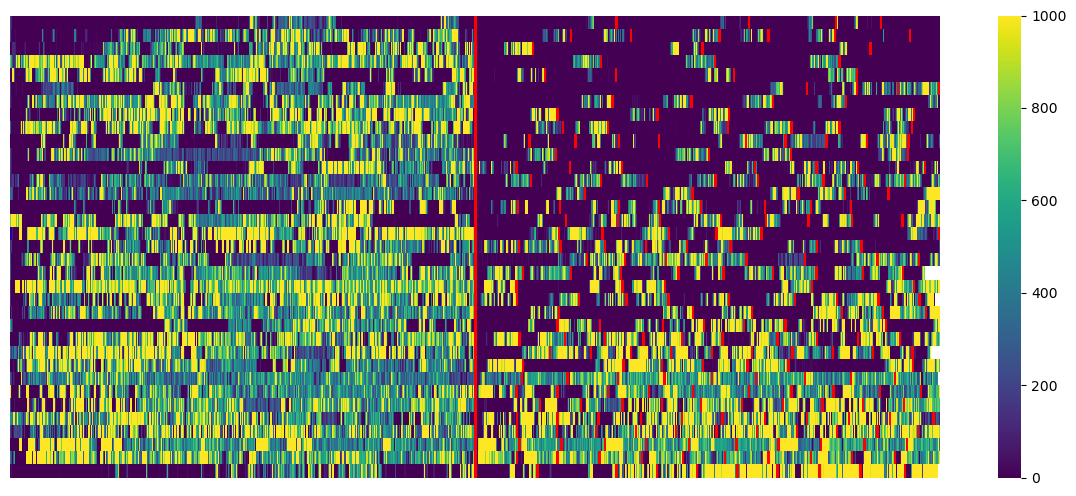

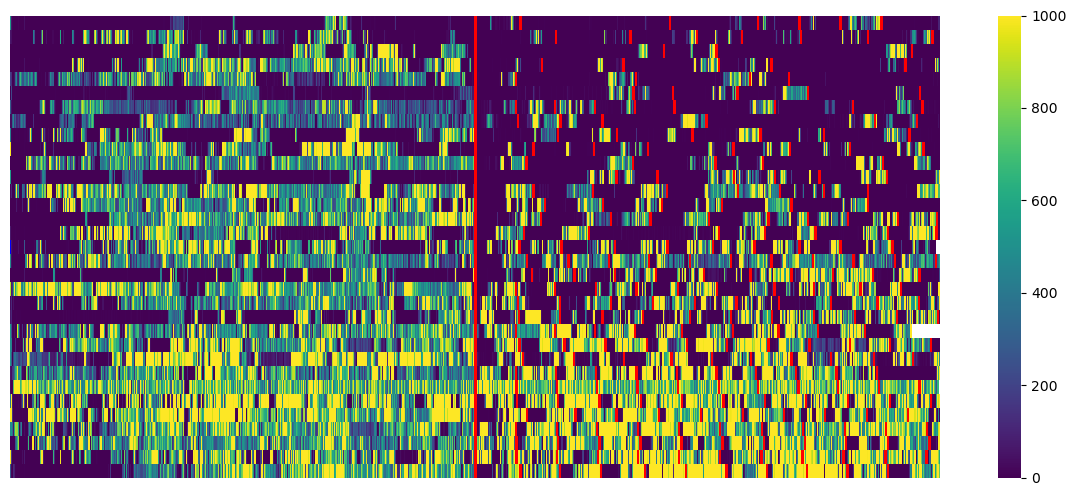

In [7]:
binned_heatmap_pixchange(data_aligned_all,pix_change_aligned_all,max_val = 1000,bins = 0.5,sort=True,figy=6)
binned_heatmap_pixchange(data_b_ligned_all,pix_change_b_ligned_all,max_val = 1000,bins = 0.5,sort=True,figy=6)


### Main Figure 3

In [7]:

def pulse_locations(data1,colour1,name1,bin_size = 1,sort = True,xlim1 = 150,save1="",align='offset',graph='yes',condition="NONE"):
    rev_order_1 = pd.DataFrame()
    rev_order_1_prob = pd.DataFrame()
    bouts_tot = 0
    eventz = []
    eventz_tot = []
    
    eventz1,eventz_tot1,stim_timez1,stim_pulses1,df_freq_all_1,rev_orderz1  = orders_locs(data1.query("phase == 'post'"),colour1,
                                                                              name1,xlim1,align=align,
                                                                              bin_size = bin_size)    
    eventz2,eventz_tot2,stim_timez2,stim_pulses2,df_freq_all_2,rev_orderz2  = orders_locs(data1.query("phase == 'pre'"),colour1,
                                                                              name1,xlim1,align=align,
                                                                              bin_size = bin_size)
    df_freq_all = pd.concat([df_freq_all_1,df_freq_all_2])
    stim_pulses_both = pd.concat([stim_pulses1,stim_pulses2])
    
    
    
    if graph == 'yes':
        eventplotting(eventz1,eventz_tot1,stim_timez1,colour1,xlim1,name1,sortz = sort,alignd = align,title = 'Post',save = save1 + "post") 
    df_freq_all["Condition"] = name1
    df_freq_all["pulse_condition"] = df_freq_all["pulse_type"] + "_" + df_freq_all["Condition"]
    
    return stim_pulses_both,df_freq_all


#
def orders_locs(data,color,name,xlim,align='offset',bin_size=1): #pause plots and pulse plots need to be ordered in the same way
    rev_order = pd.DataFrame()
    rev_order_long = pd.DataFrame()
    bouts_tot = 0
    eventz = []
    eventz_tot = []
    stim_timez = []
    stim_pulses = pd.DataFrame()
    df_freq_all = pd.DataFrame()
    count = 0
    for file in data.Filename.unique():
        dat = data.query("Filename == @file")
        end = dat.iloc[-1]
        for clip in dat.Clip.unique():
            if float(clip) > 0:
                name = file+"_"+str(clip) 
                output_df = pd.DataFrame({"Filename":[file],"Clip":[clip],"name":[name],"Experimenter":[dat.iloc[0].Experimenter]}) 
                datz = dat.query("Clip == @clip")
                if datz.iloc[0].phase == 'pre':
                    end_no = 300
                    output_df["phase"] = 'pre'
                else:
                    end_no = dat.iloc[-1].normed_time
                    output_df["phase"] = 'post'
                    
                if 0 in datz.Loom_time.unique(): #if there is a stimulation in the clip NB this shouldn't happen if the fly wasn't freezing before
                    lmz = datz.query("Loom_time == 0")
                    to_add = float(lmz.normed_time - datz.iloc[0].normed_time)
                    output_df["Loom"] = 'during'
                    
                else: #if no Loom in the clip
                    if (datz.Loom_time.unique().max()) < -1: #if the stim_time never goes postive to show there was a stim just before the freeze time
                        to_add = 1000
                        output_df["Loom"] = 'no'
                    elif (datz.query("Loom_time > 0").Loom_time.min()) > 1200: # if the freezing happened after the 10s of the stimulus
                        to_add = 1000
                        output_df["Loom"] = 'no'
                    else:
                        to_add = -datz.query("Loom_time > -999").Time_loom.unique().min() #should this be minus? This equals the entry lag
                        output_df["Loom"] = 'yes'

                #MAKING A DF HERE TO OUTPUT ALL THE FREQUENCIES
                
                output_df["pause_length"] = datz.shape[0]/frame_rate_hc
                #print(datz)
                output_df["no_of_pulses"] = datz.query("pulse == 1").shape[0]
                output_df["tot_freq"] = output_df["no_of_pulses"]/output_df["pause_length"]
                
                # here find the frequency of pulsing for only that part that is before the social_Stim_part
                sti = datz.query("Time_loom < @stim_len and Time_loom > 0")
                output_df["pre_stim_pulses"] = sti.query("pulse == 1").shape[0]
                output_df["pre_stim_time"] = sti.shape[0]/frame_rate_hc
                output_df["pre_stim_freq"] = output_df["pre_stim_pulses"]/output_df["pre_stim_time"]
                output_df["pulse_type"] = [datz.iloc[0].pulse_type]
                output_df["post_stim_time"] = datz.query("Time_loom > @stim_len and Time_loom < 190").Time_loom.max()-10 #the 10 is the stim
                output_df["post_stim_pulses"] = datz.query("Time_loom > @stim_len and pulse == 1").shape[0]
                output_df["post_stim_freq"] = output_df["post_stim_pulses"]/output_df["post_stim_time"]
                
                output_df["lag"] = datz.query("Time_loom < @stim_len and Time_loom > 0").Time_loom.min()
                if datz.query("pulse == 1").shape[0] > 0:
                    #if 
                    output_df["first_pulse_delay"] = datz.query("pulse == 1").iloc[0].normed-datz.iloc[0].normed
                    
                else:
                    output_df["first_pulse_delay"] = np.nan
                
                df_freq_all = pd.concat([df_freq_all,output_df])   
                
                if output_df.iloc[0].Loom == 'yes':
                    
                    if align == 'onset':
                        eventz_tot.append(datz.shape[0]/frame_rate_hc)
                        stim_timez.append(datz.shape[0]/frame_rate_hc+to_add)
                    elif align == 'offset': #the stim times in the reference of the end of the stim bout
                        eventz_tot.append(-datz.shape[0]/frame_rate_hc)
                        stim_timez.append(-datz.shape[0]/frame_rate_hc+to_add)
                    elif align == 'stim': #this is written in a complicated way because it was using the offset as a model
                        eventz_tot.append(-datz.shape[0]/frame_rate_hc)
                        stim_timez.append(-datz.shape[0]/frame_rate_hc+to_add)
                    
                    datz2 = datz.query("pulse == 1").backwards_aligned
                    if align == 'onset':
                        datz2 = datz2-datz.backwards_aligned.iloc[0]
                    to_add = datz2.tolist()
                    if align == 'onset':
                        to_add.append(-1)
                    else:
                        to_add.append(200)
        
                    eventz.append(to_add)
                    
                    if datz.iloc[0].Time_loom < stim_len and datz.iloc[0].Time_loom > -10:
                        bins = np.arange(stim_len-30*bin_size,stim_len+30*bin_size,bin_size)

                        binz = np.round([f for f in bins if f >= datz.iloc[0].Time_loom],2)
                        bins = np.round([f for f in binz if f <= datz.iloc[-1].Time_loom],2)
                        hists_stim = np.histogram(datz.query("pulse == 1").Time_loom,bins=bins)
                        hist_df = pd.DataFrame({"Filename":file,"Experimenter":datz.iloc[0].Experimenter,
                                                "Clip":clip,"pulse":hists_stim[0]/bin_size,
                                                "bin_centre":hists_stim[1][:-1]+bin_size/2,
                                                "file_clip":file+str(clip),"stim_aligned":hists_stim[1][:-1]-stim_len+bin_size/2})#,"bins_back":bins_back[:-1]
                        stim_pulses = pd.concat([stim_pulses,hist_df])

      
        stim_pulses["phase"] = dat.phase.iloc[0]
    #print('total_events = '+str(len(eventz_tot)))
    return eventz,eventz_tot,stim_timez,stim_pulses,df_freq_all,rev_order_long 


In [11]:
def eventplotting(data_eventz,evz_tot,stim_onset,col,xlimz,name,sortz = True,save = "",alignd='offset',title = ''):
        ev_tot = []
        sti_onset = []
    
        if sortz == 'pulse':
            k = [item[0] for item in data_eventz] #sorting by first pulse (item)
            l = np.argsort(k)
            data_eventz.sort(key=lambda x:x[0])
            evz_tot = np.asarray(evz_tot)[l]#[::-1]
            stim_onset = np.asarray(stim_onset)[l] 
        if sortz == 'length': #sorting by length of freezing bout...
            g = np.argsort(evz_tot)
            data_eventz = [data_eventz[i] for i in g] #list comprehension
            evz_tot = np.asarray(evz_tot)[g] #sorts evz_tot by g
            stim_onset = np.asarray(stim_onset)[g]
        if sortz == 'diff_stim_onset': #i.e. the difference between the stim onset and the onset of freezing
             #sorting by first pulse (item)
            j = np.flip(np.argsort(np.array(stim_onset)-np.array(evz_tot))) #flip puts the smallest at the top
            data_eventz = [data_eventz[i] for i in j] #list comprehension
            evz_tot = np.asarray(evz_tot)[j] #sorts evz_tot by g
            stim_onset = np.asarray(stim_onset)[j]
        if sortz == 'diff_stim_pulse': #i.e. the difference between the stim onset and the onset of pulsing

            k = [item[0] for item in data_eventz]
            j = np.argsort(np.array(stim_onset)-np.array(k))
            data_eventz = [data_eventz[i] for i in j] #list comprehension
            evz_tot = np.asarray(evz_tot)[j] #sorts evz_tot by g
            stim_onset = np.asarray(stim_onset)[j]    
        
        if sortz == 'chrono': #chronological
            pass

        for eac in evz_tot:
            ev_tot.append([eac])

        for eac in stim_onset:
            sti_onset.append([eac])

        
        evz_tot_stim = []
        evz_tot_nostim = []
        data_eventz_stim = []
        data_eventz_nostim = []
        ev_tot_stim = []
        ev_tot_nostim = []
        sti_onset_stim = []
        sti_onset_nostim = []
        freeze_offset_stim = []
        freeze_offset_nostim = []
        ev_length_stim = []
        ev_length_nostim = []

        if alignd == 'stim':
            freeze_offset = []
            for v,entry in enumerate(stim_onset):
                if entry < 0: #below 0 means there was a stimulus
                    if -entry >= stim_len: #this is to exclude the ones that finish before the start of the stim
                    
                        data_eventz_stim.append(data_eventz[v]-entry)
                        ev_tot_stim.append(ev_tot[v]-entry)
                        sti_onset_stim.append(sti_onset[v]-entry)
                        evz_tot_stim.append(evz_tot[v]-entry)
                        freeze_offset_stim.append([-entry])
                        ev_length_stim.append(-evz_tot[v])
                    
                else:
                    data_eventz_nostim.append(data_eventz[v]-entry)
                    ev_tot_nostim.append(ev_tot[v]-entry)
                    sti_onset_nostim.append(sti_onset[v]-entry)
                    evz_tot_nostim.append(evz_tot[v]-entry)
                    freeze_offset_nostim.append([-entry])
                    ev_length_nostim.append(-evz_tot[v])

            sti_offset = np.asarray(sti_onset)+stim_len #would need to change sign if alignment=onset
            sti_offset_stim = np.asarray(sti_onset_stim)+stim_len #would need to change sign if alignment=onset
            sti_offset_nostim = np.asarray(sti_onset_nostim)+stim_len #would need to change sign if alignment=onset

        if alignd == 'offset':   
            for v,entry in enumerate(stim_onset): #v refers to the enumerate part of the list
                if entry < 0:
                    data_eventz_stim.append(data_eventz[v])
                    ev_tot_stim.append(ev_tot[v])
                    sti_onset_stim.append(sti_onset[v])
                    evz_tot_stim.append(evz_tot[v])
                else:
                    data_eventz_nostim.append(data_eventz[v])
                    ev_tot_nostim.append(ev_tot[v])
                    sti_onset_nostim.append(sti_onset[v])
                    evz_tot_nostim.append(evz_tot[v])
            
            sti_offset = np.asarray(sti_onset)+stim_len #would need to change sign if alignment=onset
            sti_offset_stim = np.asarray(sti_onset_stim)+stim_len #would need to change sign if alignment=onset
            sti_offset_nostim = np.asarray(sti_onset_nostim)+stim_len

        if alignd == 'onset':  
            for v,entry in enumerate(stim_onset): #v refers to the enumerate part of the list
                if entry < 0:
                    data_eventz_stim.append(data_eventz[v]-evz_tot[v])
                    ev_tot_stim.append(ev_tot[v]-evz_tot[v])
                    sti_onset_stim.append(sti_onset[v]-evz_tot[v])
                    evz_tot_stim.append(evz_tot[v]-evz_tot[v])
                    ev_length_stim.append(-evz_tot[v])
                else:
                    data_eventz_nostim.append(data_eventz[v]-evz_tot[v])
                    ev_tot_nostim.append(ev_tot[v]-evz_tot[v])
                    sti_onset_nostim.append(sti_onset[v]-evz_tot[v])
                    evz_tot_nostim.append(evz_tot[v]-evz_tot[v])
                    ev_length_nostim.append(-evz_tot[v])
            
            sti_offset = np.asarray(sti_onset)+stim_len #would need to change sign if alignment=onset
            sti_offset_stim = np.asarray(sti_onset_stim)+stim_len #would need to change sign if alignment=onset
            sti_offset_nostim = np.asarray(sti_onset_nostim)+stim_len
            
        figure_size_x = xlimz/30
        y_axis_modulator = 0.05
        white_widths = 2
        light_lines = 1
        print(len(ev_tot_stim))
        
        if alignd == 'stim': 
            
            figure_size_y = len(ev_tot_stim)*y_axis_modulator
            
            fig,ax1 = plt.subplots(figsize=(figure_size_x,figure_size_y)) #formatting
            ax1.set_facecolor("lightgrey")
            plt.xlim([-1,xlimz])
            plt.plot([np.array(evz_tot_stim)+0.01,np.array(evz_tot_stim)+np.array(ev_length_stim)],
                     [np.arange(len(evz_tot_stim)),np.arange(len(evz_tot_stim))],
                     c=[1,1,1],linewidth=white_widths,zorder=1)
            plt.eventplot(data_eventz_stim,color=col,label=name,linelengths=0.8,linewidths=0.4,zorder=2) #plots the pulses    
            plt.eventplot(ev_tot_stim,color='k',label=name,linelengths=0.8,linewidths = light_lines,zorder=3) #plots the pause_onsets
            plt.eventplot(sti_onset_stim,color='red',label=name,linelengths=0.8,linewidths = light_lines,zorder=3) #orange lines for red LED onset
            plt.eventplot(sti_offset_stim,color='lightcoral',label=name,linelengths=0.8,linewidths = light_lines,zorder=3) #orange lines for red LED offset      
            plt.eventplot(freeze_offset,color='k',label=name,linelengths=0.8,linewidths = light_lines,zorder=3) #orange lines for red LED offset      
            plt.ylim([-1,len(ev_tot_stim)])
            ax1.spines['right'].set_visible(False)
            ax1.spines['top'].set_visible(False)
            ax1.spines['left'].set_bounds(0,len(ev_tot_stim))
            plt.xlabel("Time from loom (s)",fontsize = 11)
            plt.xticks(fontsize = 9)
            plt.tick_params(axis='y',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    left=False,
                    labelleft=False)
            if len(save) > 0:
                fig.savefig(save+"_stimaligned_withstim.svg")

In [13]:
stim_pulses_aligned_all,frq_all_clips_aligned_all = pulse_locations(data_aligned_all,'#7AB77D','No Motion',
            bin_size=1,sort = 'length',xlim1 = 140,condition="No Motion",align='stim',graph='no',save1=save_location+"No_mot_cue")#,

stim_pulses_b_ligned_all,frq_all_clips_b_ligned_all = pulse_locations(data_b_ligned_all,'#537A5A','Motion',
              bin_size=1,sort = 'length',xlim1 = 140,condition="Motion",align='stim',graph='no',save1=save_location+"With_mot_cue")#,



### Freeze length after motion cue Fig 3F

In [20]:
frq_bout_all = pd.concat([frq_all_clips_aligned_all,frq_all_clips_b_ligned_all])
frq_bout_all.reset_index(inplace=True)

In [27]:
frq_bout_all

,index,Filename,Clip,name,Experimenter,phase,Loom,pause_length,no_of_pulses,tot_freq,pre_stim_pulses,pre_stim_time,pre_stim_freq,pulse_type,post_stim_time,post_stim_pulses,post_stim_freq,lag,first_pulse_delay,Condition,pulse_condition
0,0,231020_CSlfxAS008_fly10,15493.0,231020_CSlfxAS008_fly10_15493.0,Mariana,post,yes,33.50,16,0.477612,1,10.12,0.098814,Pulsing,24.100,15,0.622407,0.583,9.4213,No Motion,Pulsing_No Motion
1,0,231020_CSlfxAS008_fly10,17468.0,231020_CSlfxAS008_fly10_17468.0,Mariana,post,no,6.18,12,1.941748,0,0.00,NaN,N/a,36.342,12,0.330196,NaN,0.1750,No Motion,N/a_No Motion
2,0,231020_CSlfxAS008_fly10,19580.0,231020_CSlfxAS008_fly10_19580.0,Mariana,post,yes,12.12,7,0.577558,5,10.06,0.497018,Pulsing,2.742,2,0.729395,0.642,0.5997,No Motion,Pulsing_No Motion
3,0,231020_CSlfxAS008_fly10,20192.0,231020_CSlfxAS008_fly10_20192.0,Mariana,post,no,11.76,7,0.595238,0,0.00,NaN,N/a,14.642,7,0.478077,NaN,0.7749,No Motion,N/a_No Motion
4,0,231020_CSlfxAS008_fly10,21726.0,231020_CSlfxAS008_fly10_21726.0,Mariana,post,yes,4.20,0,0.000000,0,4.20,0.000000,N/a,NaN,0,NaN,0.625,NaN,No Motion,N/a_No Motion
5,0,231020_CSlfxAS008_fly10,21942.0,231020_CSlfxAS008_fly10_21942.0,Mariana,post,yes,7.52,1,0.132979,1,5.76,0.173611,Pulsing,2.458,0,0.000000,4.950,5.1229,No Motion,Pulsing_No Motion
6,0,231020_CSlfxAS008_fly10,22547.0,231020_CSlfxAS008_fly10_22547.0,Mariana,post,no,7.14,10,1.400560,0,0.00,NaN,N/a,14.192,10,0.704622,NaN,0.6581,No Motion,N/a_No Motion
7,0,231020_CSlfxAS008_fly10,22909.0,231020_CSlfxAS008_fly10_22909.0,Mariana,post,during,6.80,5,0.735294,0,0.46,0.000000,Pulsing,15.625,1,0.064000,0.017,1.1411,No Motion,Pulsing_No Motion
8,0,231020_CSlfxAS008_fly10,24685.0,231020_CSlfxAS008_fly10_24685.0,Mariana,post,yes,93.96,27,0.287356,0,10.18,0.000000,Quiescent,84.550,27,0.319338,0.517,23.5151,No Motion,Quiescent_No Motion
9,0,231020_CSlfxAS008_fly30,15490.0,231020_CSlfxAS008_fly30_15490.0,Mariana,post,yes,51.48,2,0.038850,0,10.00,0.000000,Quiescent,42.225,2,0.047365,0.700,49.3790,No Motion,Quiescent_No Motion


N = 102
N = 103
MannwhitneyuResult(statistic=19783.5, pvalue=0.02622665810845085)


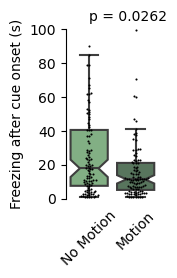

In [30]:
pal = sns.color_palette(['#7AB77D','#537A5A'])

frq_bout_all = pd.concat([frq_all_clips_aligned_all,frq_all_clips_b_ligned_all])
frq_bout_all.reset_index(inplace=True)

print("N = "+str(frq_bout_all.query("Loom == 'yes' and Condition == 'No Motion' and post_stim_time > 0").shape[0]))
print("N = "+str(frq_bout_all.query("Loom == 'yes' and Condition == 'Motion' and post_stim_time > 0").shape[0]))
    

fig,ax = plt.subplots(figsize=([1.2,2.2]))
#sns.violinplot(data=frq_bout_all.query("Loom == 'yes'"),x="Condition",y="post_stim_time",fliersize=0,linewidth=1,cut=0,inner='quart',palette=pal)
sns.boxplot(data=frq_bout_all.query("Loom == 'yes'"),x
            ="Condition",y="post_stim_time",fliersize=0,notch=True,palette=pal)
sns.swarmplot(data=frq_bout_all.query("Loom == 'yes'"),x="Condition",y="post_stim_time",c='k',size=1.5)
plt.ylim([0,100])
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.ylabel("Freezing after cue onset (s)",fontsize = 10)
plt.xlabel("")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['left'].set_bounds(0,3.2)
plt.tick_params(axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,rotation=45)
#for l in ax.lines:
#    l.set_linewidth(0.75)
#    l.set_linestyle('solid')
#for l in ax.lines[1::3]:
#    l.set_linewidth(4)
#ax1.spines['left'].set_bounds(0,len(evz_tot))
ax.spines['bottom'].set_visible(False)
p_sep = sp.posthoc_dunn(frq_bout_all.query("post_stim_time>=0"),val_col = 'post_stim_time',group_col="Condition", p_adjust = 'bonferroni')
plt.text(0,105,"p = "+str(p_sep.iloc[0,1].round(4)),fontsize=10)
p = stats.mannwhitneyu(frq_bout_all.query("post_stim_time>=0 and Condition == 'No Motion'").post_stim_time,
                      frq_bout_all.query("post_stim_time>=0 and Condition == 'Motion'").post_stim_time)
fig.savefig(save_location+"freezing_after_socstim.svg")
print(p)

### rasters for pulsing vs quiescent: supplementary figure

In [16]:
def pulse_locations(data1,colour1,name1,bin_size = 1,sort = True,xlim1 = 150,save1="",align='offset',graph='yes',condition="NONE"):
    rev_order_1 = pd.DataFrame()
    rev_order_1_prob = pd.DataFrame()
    bouts_tot = 0
    eventz = []
    eventz_tot = []
    
    eventz1,eventz_tot1,stim_timez1,stim_pulses1,df_freq_all_1,rev_orderz1  = orders_locs(data1,colour1,
                                                                              name1,xlim1,align=align,
                                                                              bin_size = bin_size,typez = 'Pulsing')  
    eventz2,eventz_tot2,stim_timez2,stim_pulses2,df_freq_all_2,rev_orderz2  = orders_locs(data1,colour1,
                                                                              name1,xlim1,align=align,
                                                                              bin_size = bin_size,typez = 'Quiescent') 
    #eventz2,eventz_tot2,stim_timez2,stim_pulses2,df_freq_all_2,rev_orderz2  = orders_locs(data1,colour1,
    #                                                                          name1,xlim1,align=align,
    #                                                                          bin_size = bin_size,typez = 'Quiescenct')
    #df_freq_all = pd.concat([df_freq_all_1,df_freq_all_2])
    #stim_pulses_both = pd.concat([stim_pulses1,stim_pulses2])
    
    
    
    if graph == 'yes':
        eventplotting(eventz1,eventz_tot1,stim_timez1,colour1,xlim1,name1,sortz = sort,alignd = align,title = 'Pulsing',save = save1 + "Pulsing") 
        eventplotting(eventz2,eventz_tot2,stim_timez2,colour1,xlim1,name1,sortz = sort,alignd = align,title = 'Quiescent',save = save1 + "Quiescent") 
    #df_freq_all_1["Condition"] = name1
    #df_freq_all_1["pulse_condition"] = df_freq_all_1["pulse_type"] + "_" + df_freq_all_1["Condition"]
    
    #return df_freq_all_1 #stim_pulses_both,




def orders_locs(data,color,name,xlim,align='offset',bin_size=1,typez = ''): #pause plots and pulse plots need to be ordered in the same way
    rev_order = pd.DataFrame()
    rev_order_long = pd.DataFrame()
    bouts_tot = 0
    eventz = []
    eventz_tot = []
    stim_timez = []
    stim_pulses = pd.DataFrame()
    df_freq_all = pd.DataFrame()
    count = 0
    for file in data.Filename.unique():
        dat = data.query("Filename == @file")
        end = dat.iloc[-1]
        if len(typez) > 0:
            dat = dat.query("pulse_type == @typez")
        cleaned = [x for x in dat.Clip.unique() if str(x) != 'nan']
        if len(cleaned) > 0:
            #print(dat.shape)
        #else:
        #    dat1 = dat
            for k, clip in enumerate(dat.Clip.unique()):
                if float(clip) > 0:
                    #print(clip)
                    name = file+"_"+str(clip) 
                    output_df = pd.DataFrame({"Filename":[file],"Clip":[clip],"name":[name],"Experimenter":[dat.iloc[0].Experimenter]}) 
                    datz = dat.query("Clip == @clip")
                    #print(datz.shape)
                    if datz.iloc[0].phase == 'pre':
                        end_no = 300
                        output_df["phase"] = 'pre'
                    else:
                        end_no = dat.iloc[-1].normed_time
                        output_df["phase"] = 'post'
                        
                    if 0 in datz.Loom_time.unique(): #if there is a Loom in the clip NB this shouldn't happen if the fly wasn't freezing before
                        lmz = datz.query("Loom_time == 0")
                        to_add = float(lmz.normed_time - datz.iloc[0].normed_time)
                        output_df["Loom"] = 'during'
                        
                    else: #if no Loom in the clip
                        
                        if (datz.Loom_time.unique().max()) < -1: #if the stim_time never goes postive to show there was a stim just before the freeze time
                            to_add = 1000
                            output_df["Loom"] = 'no'
                            #print("went one")
                        elif (datz.query("Loom_time > 0").Loom_time.min()) > 1200: # if the freezing happened after the 10s of the stimulus
                            to_add = 1000
                            output_df["Loom"] = 'no'
                            #print("went two")
                        else:
                            to_add = -datz.query("Loom_time > -999").Time_loom.unique().min() #should this be minus? This equals the entry lag
                            output_df["Loom"] = 'yes'
                            #print("went three")
                            #print(output_df)
    
                    #MAKING A DF HERE TO OUTPUT ALL THE FREQUENCIES
                    
                    output_df["pause_length"] = datz.shape[0]/frame_rate_hc
                    #print(datz)
                    output_df["no_of_pulses"] = datz.query("pulse == 1").shape[0]
                    output_df["tot_freq"] = output_df["no_of_pulses"]/output_df["pause_length"]
                    
                    # here find the frequency of pulsing for only that part that is before the social_Stim_part
                    sti = datz.query("Time_loom < @stim_len and Time_loom > 0")
                    output_df["pre_stim_pulses"] = sti.query("pulse == 1").shape[0]
                    output_df["pre_stim_time"] = sti.shape[0]/frame_rate_hc
                    output_df["pre_stim_freq"] = output_df["pre_stim_pulses"]/output_df["pre_stim_time"]
                    output_df["pulse_type"] = [datz.iloc[0].pulse_type]
                    output_df["post_stim_time"] = datz.query("Time_loom > @stim_len and Time_loom < 190").Time_loom.max()-10 #the 10 is the stim
                    output_df["post_stim_pulses"] = datz.query("Time_loom > @stim_len and pulse == 1").shape[0]
                    output_df["post_stim_freq"] = output_df["post_stim_pulses"]/output_df["post_stim_time"]
                    
                    output_df["lag"] = datz.query("Time_loom < @stim_len and Time_loom > 0").Time_loom.min()
                    if datz.query("pulse == 1").shape[0] > 0:
                        #if 
                        output_df["first_pulse_delay"] = datz.query("pulse == 1").iloc[0].normed-datz.iloc[0].normed
                        
                    else:
                        output_df["first_pulse_delay"] = np.nan
                    
                    df_freq_all = pd.concat([df_freq_all,output_df])   
                    #print(output_df.head())
                    
                    
                    if output_df.iloc[0].Loom == 'yes':
                        #print('Loom yes')
                        if align == 'onset':
                            eventz_tot.append(datz.shape[0]/frame_rate_hc)
                            stim_timez.append(datz.shape[0]/frame_rate_hc+to_add)
                        elif align == 'offset': #the stim times in the reference of the end of the stim bout
                            eventz_tot.append(-datz.shape[0]/frame_rate_hc)
                            stim_timez.append(-datz.shape[0]/frame_rate_hc+to_add)
                        elif align == 'stim': #this is written in a complicated way because it was using the offset as a model
                            #print("reached here")
                            eventz_tot.append(-datz.shape[0]/frame_rate_hc)
                            stim_timez.append(-datz.shape[0]/frame_rate_hc+to_add)
                        
                        datz2 = datz.query("pulse == 1").backwards_aligned
                        if align == 'onset':
                            datz2 = datz2-datz.backwards_aligned.iloc[0]
                        to_add = datz2.tolist()
                        if align == 'onset':
                            to_add.append(-1)
                        else:
                            to_add.append(200)
            
                        eventz.append(to_add)
                        
                        if datz.iloc[0].Time_loom < stim_len and datz.iloc[0].Time_loom > -10:
                            bins = np.arange(stim_len-30*bin_size,stim_len+30*bin_size,bin_size)
    
                            binz = np.round([f for f in bins if f >= datz.iloc[0].Time_loom],2)
                            bins = np.round([f for f in binz if f <= datz.iloc[-1].Time_loom],2)
                            hists_stim = np.histogram(datz.query("pulse == 1").Time_loom,bins=bins)
                            hist_df = pd.DataFrame({"Filename":file,"Experimenter":datz.iloc[0].Experimenter,
                                                    "Clip":clip,"pulse":hists_stim[0]/bin_size,
                                                    "bin_centre":hists_stim[1][:-1]+bin_size/2,
                                                    "file_clip":file+str(clip),"stim_aligned":hists_stim[1][:-1]-stim_len+bin_size/2})#,"bins_back":bins_back[:-1]
                            stim_pulses = pd.concat([stim_pulses,hist_df])
    
          
            #stim_pulses["phase"] = dat.phase.iloc[0]
    print('total_events = '+str(len(eventz_tot)))
    return eventz,eventz_tot,stim_timez,stim_pulses,df_freq_all,rev_order_long


def eventplotting(data_eventz,evz_tot,stim_onset,col,xlimz,name,sortz = True,save = "",alignd='offset',title = ''):
        ev_tot = []
        sti_onset = []
    
        if sortz == 'pulse':
            k = [item[0] for item in data_eventz] #sorting by first pulse (item)
            l = np.argsort(k)
            data_eventz.sort(key=lambda x:x[0])
            evz_tot = np.asarray(evz_tot)[l]#[::-1]
            stim_onset = np.asarray(stim_onset)[l] 
        if sortz == 'length': #sorting by length of freezing bout...
            g = np.argsort(evz_tot)
            data_eventz = [data_eventz[i] for i in g] #list comprehension
            evz_tot = np.asarray(evz_tot)[g] #sorts evz_tot by g
            stim_onset = np.asarray(stim_onset)[g]
        if sortz == 'diff_stim_onset': #i.e. the difference between the stim onset and the onset of freezing
             #sorting by first pulse (item)
            j = np.flip(np.argsort(np.array(stim_onset)-np.array(evz_tot))) #flip puts the smallest at the top
            data_eventz = [data_eventz[i] for i in j] #list comprehension
            evz_tot = np.asarray(evz_tot)[j] #sorts evz_tot by g
            stim_onset = np.asarray(stim_onset)[j]
        if sortz == 'diff_stim_pulse': #i.e. the difference between the stim onset and the onset of pulsing

            k = [item[0] for item in data_eventz]
            j = np.argsort(np.array(stim_onset)-np.array(k))
            data_eventz = [data_eventz[i] for i in j] #list comprehension
            evz_tot = np.asarray(evz_tot)[j] #sorts evz_tot by g
            stim_onset = np.asarray(stim_onset)[j]    
        
        if sortz == 'chrono': #chronological
            pass

        for eac in evz_tot:
            ev_tot.append([eac])

        for eac in stim_onset:
            sti_onset.append([eac])

        
        evz_tot_stim = []
        evz_tot_nostim = []
        data_eventz_stim = []
        data_eventz_nostim = []
        ev_tot_stim = []
        ev_tot_nostim = []
        sti_onset_stim = []
        sti_onset_nostim = []
        freeze_offset_stim = []
        freeze_offset_nostim = []
        ev_length_stim = []
        ev_length_nostim = []

        if alignd == 'stim':
            freeze_offset = []
            for v,entry in enumerate(stim_onset):
                if entry < 0: #below 0 means there was a stimulus
                    if -entry >= stim_len: #this is to exclude the ones that finish before the start of the stim
                    
                        data_eventz_stim.append(data_eventz[v]-entry)
                        ev_tot_stim.append(ev_tot[v]-entry)
                        sti_onset_stim.append(sti_onset[v]-entry)
                        evz_tot_stim.append(evz_tot[v]-entry)
                        freeze_offset_stim.append([-entry])
                        ev_length_stim.append(-evz_tot[v])
                    
                else:
                    data_eventz_nostim.append(data_eventz[v]-entry)
                    ev_tot_nostim.append(ev_tot[v]-entry)
                    sti_onset_nostim.append(sti_onset[v]-entry)
                    evz_tot_nostim.append(evz_tot[v]-entry)
                    freeze_offset_nostim.append([-entry])
                    ev_length_nostim.append(-evz_tot[v])

            sti_offset = np.asarray(sti_onset)+stim_len #would need to change sign if alignment=onset
            sti_offset_stim = np.asarray(sti_onset_stim)+stim_len #would need to change sign if alignment=onset
            sti_offset_nostim = np.asarray(sti_onset_nostim)+stim_len #would need to change sign if alignment=onset

        if alignd == 'offset':   
            for v,entry in enumerate(stim_onset): #v refers to the enumerate part of the list
                if entry < 0:
                    data_eventz_stim.append(data_eventz[v])
                    ev_tot_stim.append(ev_tot[v])
                    sti_onset_stim.append(sti_onset[v])
                    evz_tot_stim.append(evz_tot[v])
                else:
                    data_eventz_nostim.append(data_eventz[v])
                    ev_tot_nostim.append(ev_tot[v])
                    sti_onset_nostim.append(sti_onset[v])
                    evz_tot_nostim.append(evz_tot[v])
            
            sti_offset = np.asarray(sti_onset)+stim_len #would need to change sign if alignment=onset
            sti_offset_stim = np.asarray(sti_onset_stim)+stim_len #would need to change sign if alignment=onset
            sti_offset_nostim = np.asarray(sti_onset_nostim)+stim_len

       # if alignd == 'onset':  
       #     for v,entry in enumerate(stim_onset): #v refers to the enumerate part of the list
       #         if entry < 0:
       #             data_eventz_stim.append(data_eventz[v]-evz_tot[v])
       #             ev_tot_stim.append(ev_tot[v]-evz_tot[v])
       #             sti_onset_stim.append(sti_onset[v]-evz_tot[v])
       #             evz_tot_stim.append(evz_tot[v]-evz_tot[v])
       #             ev_length_stim.append(-evz_tot[v])
       #         else:
       #             data_eventz_nostim.append(data_eventz[v]-evz_tot[v])
       #             ev_tot_nostim.append(ev_tot[v]-evz_tot[v])
       #             sti_onset_nostim.append(sti_onset[v]-evz_tot[v])
       #             evz_tot_nostim.append(evz_tot[v]-evz_tot[v])
       #             ev_length_nostim.append(-evz_tot[v])
       #     
       #     sti_offset = np.asarray(sti_onset)+stim_len #would need to change sign if alignment=onset
       #     sti_offset_stim = np.asarray(sti_onset_stim)+stim_len #would need to change sign if alignment=onset
       #     sti_offset_nostim = np.asarray(sti_onset_nostim)+stim_len
       #     
        figure_size_x = xlimz/28
        y_axis_modulator = 0.05
        white_widths = 2
        light_lines = 1
        print(len(ev_tot_stim))
        
        if alignd == 'stim': 
            fig,ax1 = plt.subplots(figsize=(figure_size_x,len(evz_tot_stim)*0.05))
            #figure_size_y = len(ev_tot_stim)*y_axis_modulator
            
            #fig,ax1 = plt.subplots(figsize=(figure_size_x,figure_size_y)) #formatting
            ax1.set_facecolor("lightgrey")
            #plt.hlines(len(evz_tot_stim)/2,0,stim_len,color='pink',linewidth=400)
            plt.xlim([-1,xlimz])
            plt.plot([np.array(evz_tot_stim),np.array(evz_tot_stim)+np.array(ev_length_stim)],
                     [np.arange(len(evz_tot_stim)),np.arange(len(evz_tot_stim))],
                     c=[1,1,1],linewidth=white_widths,zorder=2)
            plt.eventplot(data_eventz_stim,color=col,label=name,linelengths=0.8,linewidths=0.4,zorder=3) #plots the pulses    
            plt.eventplot(np.array(ev_tot_stim)-0.5,color='k',label=name,linelengths=0.8,linewidths = light_lines,zorder=4) #plots the pause_onsets
            plt.eventplot(sti_onset_stim,color='red',label=name,linelengths=0.8,linewidths = light_lines,zorder=4) #orange lines for red LED onset
            plt.eventplot(sti_offset_stim,color='lightcoral',label=name,linelengths=0.8,linewidths = light_lines,zorder=3) #orange lines for red LED offset      
            plt.eventplot(freeze_offset,color='k',label=name,linelengths=0.8,linewidths = light_lines,zorder=4) #orange lines for red LED offset      
            plt.ylim([-1,len(ev_tot_stim)])
            ax1.spines['right'].set_visible(False)
            ax1.spines['top'].set_visible(False)
            ax1.spines['left'].set_visible(False)
            plt.xlabel("Time from loom (s)",fontsize = 11)
            plt.xticks(fontsize = 9)
            plt.tick_params(axis='y',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    left=False,
                    labelleft=False)
            if len(save) > 0:
                fig.savefig(save+"_stimaligned_withstim.svg")

In [ ]:
 if alignd == 'stim': 
            
            figure_size_y = len(ev_tot_stim)*y_axis_modulator
            
            fig,ax1 = plt.subplots(figsize=(figure_size_x,figure_size_y)) #formatting
            ax1.set_facecolor("lightgrey")
            plt.xlim([-1,xlimz])
            plt.plot([np.array(evz_tot_stim)+0.01,np.array(evz_tot_stim)+np.array(ev_length_stim)],
                     [np.arange(len(evz_tot_stim)),np.arange(len(evz_tot_stim))],
                     c=[1,1,1],linewidth=white_widths,zorder=1)
            plt.eventplot(data_eventz_stim,color=col,label=name,linelengths=0.8,linewidths=0.4,zorder=2) #plots the pulses    
            plt.eventplot(ev_tot_stim,color='k',label=name,linelengths=0.8,linewidths = light_lines,zorder=3) #plots the pause_onsets
            plt.eventplot(sti_onset_stim,color='red',label=name,linelengths=0.8,linewidths = light_lines,zorder=3) #orange lines for red LED onset
            plt.eventplot(sti_offset_stim,color='lightcoral',label=name,linelengths=0.8,linewidths = light_lines,zorder=3) #orange lines for red LED offset      
            plt.eventplot(freeze_offset,color='k',label=name,linelengths=0.8,linewidths = light_lines,zorder=3) #orange lines for red LED offset      
            plt.ylim([-1,len(ev_tot_stim)])
            ax1.spines['right'].set_visible(False)
            ax1.spines['top'].set_visible(False)
            ax1.spines['left'].set_bounds(0,len(ev_tot_stim))
            plt.xlabel("Time from loom (s)",fontsize = 11)
            plt.xticks(fontsize = 9)
            plt.tick_params(axis='y',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    left=False,
                    labelleft=False)
            if len(save) > 0:
                fig.savefig(save+"_stimaligned_withstim.svg")

total_events = 73
total_events = 29
72
29
total_events = 55
total_events = 48
55
48


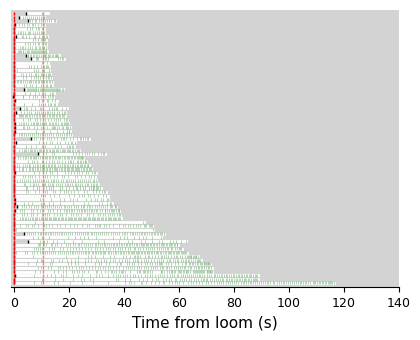

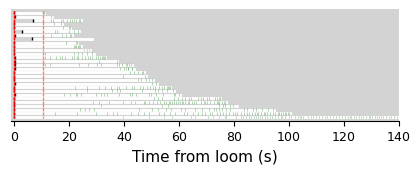

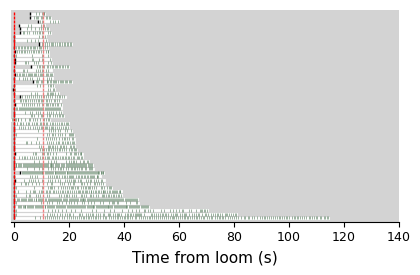

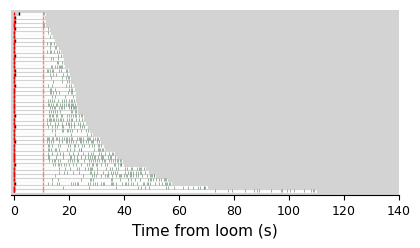

In [17]:
pulse_locations(data_aligned_all.query("phase == 'post'"),'#7AB77D','Pulsing',
            sort = 'length',xlim1 = 140,condition="No Motion",align='stim',
                save1=save_location+"No_mot_cue")#,

pulse_locations(data_b_ligned_all.query("phase == 'post'"),'#537A5A','Quiescent',
            sort = 'length',xlim1 = 140,condition="Motion",align='stim',
                save1=save_location+"W_mot_cue")#,



### Frequency around the soc cue onset

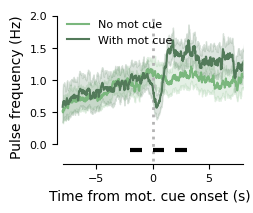

In [14]:
timepoints = [-2,0,2]
low = -8
upp = 8.5
fig,ax = plt.subplots(figsize=([2.4,2]))
plt.vlines(0,-0.25,2,linewidth = 2,color = [0.7,0.7,0.7],linestyle = ":")
sns.lineplot(data_aligned_all.query("Soc_stim_time > @low and Soc_stim_time < @upp and pulse_type == 'Pulsing'"),x="Soc_stim_time",y="rollingx",label="No mot cue",color='#7AB77D')
sns.lineplot(data_b_ligned_all.query("Soc_stim_time > @low and Soc_stim_time < @upp and pulse_type == 'Pulsing'"),x="Soc_stim_time",y="rollingx",label="With mot cue",color='#537A5A')
for tim in timepoints:
    plt.hlines(-0.09,tim,tim+1,color='k',linewidth = 3)

ax.set_ylim([-0.3,2.1])
plt.ylabel("Pulse frequency (Hz)",fontsize = 10)
plt.xlabel("Time from mot. cue onset (s)",fontsize = 10)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_bounds(-8,8)
ax.spines['left'].set_bounds(0,2)
plt.xlim(-8.5,8)
ax.legend(frameon = False,loc='upper left',fontsize = 8)

plt.savefig(save_location+"frequency_around_socstim_rolling_pulsers.svg",bbox_inches='tight')

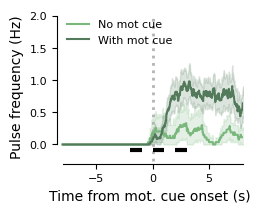

In [15]:
timepoints = [-2,0,2]
low = -8
upp = 8.5
fig,ax = plt.subplots(figsize=([2.4,2]))
plt.vlines(0,-0.25,2,linewidth = 2,color = [0.7,0.7,0.7],linestyle = ":")
sns.lineplot(data_aligned_all.query("Soc_stim_time > @low and Soc_stim_time < @upp and pulse_type == 'Quiescent'"),x="Soc_stim_time",y="rollingx",label="No mot cue",color='#7AB77D')
sns.lineplot(data_b_ligned_all.query("Soc_stim_time > @low and Soc_stim_time < @upp and pulse_type == 'Quiescent'"),x="Soc_stim_time",y="rollingx",label="With mot cue",color='#537A5A')
for tim in timepoints:
    plt.hlines(-0.09,tim,tim+1,color='k',linewidth = 3)

ax.set_ylim([-0.3,2.1])
plt.ylabel("Pulse frequency (Hz)",fontsize = 10)
plt.xlabel("Time from mot. cue onset (s)",fontsize = 10)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_bounds(-8,8)
ax.spines['left'].set_bounds(0,2)
plt.xlim(-8.5,8)
ax.legend(frameon = False,loc='upper left',fontsize = 8)

plt.savefig(save_location+"frequency_around_socstim_rolling_quiescent.svg",bbox_inches='tight')

### Friedmans anova

In [33]:
def friedmans_anova_data(data,timepoints=[-2,0,2]):
    output = pd.DataFrame()
    for file in data.concat_filestim.unique():
        #print(file)
        daz = data.query("concat_filestim == @file")
        outputz = []
        types = []
        for time in timepoints:
            
            time_up = time+1 #i.e. take the one second from the timepoint beginning
            da = daz.query("Soc_stim_time > @time and Soc_stim_time < @time_up")
            #print(da.head())
            puls = da.rollingx.mean()
            if puls >= 0:
                outputz.append(puls)
                types.append(da.iloc[0].pulse_type)
            else:
                pass
        
        if len(outputz) == 3:
            to_add = pd.DataFrame({"concat_filestim":[file],
                                            "-2:-1":[outputz[0]],
                                            "0:1":[outputz[1]],
                                           "2:3":[outputz[2]],
                                            "pulse_type":[types[0]]})
            #print(to_add)
            output = pd.concat([output,to_add])
    return(output)

In [34]:
aligned_fried = friedmans_anova_data(data_aligned_all)
bligned_fried = friedmans_anova_data(data_b_ligned_all)

In [41]:
def graph_fried(dataz,save="",colour="green"):
    
    data = dataz.melt(id_vars=["concat_filestim","pulse_type"], var_name='timepoint', value_name='value')
    
    
    fig,ax = plt.subplots(figsize=([0.7,2]))
    sns.swarmplot(data=data.query("pulse_type == 'Pulsing'"),
              x='timepoint',y='value',c='k',size=2,order = ["-2:-1","0:1","2:3"])
    sns.boxplot(data=data.query("pulse_type == 'Pulsing'"),
                  x='timepoint',y='value',order = ["-2:-1","0:1","2:3"],notch=True,fliersize=0,color=colour)#cut=0)
    plt.ylim(0,3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.tick_params(axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False)
    ax.set_ylabel("Pulse frequency (Hz)",fontsize = 10)
    
    s,p = stats.friedmanchisquare(dataz.query("pulse_type == 'Pulsing'")["-2:-1"], 
                            dataz.query("pulse_type == 'Pulsing'")["0:1"], 
                            dataz.query("pulse_type == 'Pulsing'")["2:3"])

    plt.text(0.1,3,"p = "+str(p.round(4)),fontsize=10)
    ax.set_xticks([0,1,2],labels = ["a","b","c"])
    if len(save) > 0:
        #print("yes")
        fig.savefig(save_location+save+"_pulsers.svg")
        
    datam = np.array([dataz.query("pulse_type == 'Pulsing'")["-2:-1"], 
                  dataz.query("pulse_type == 'Pulsing'")["0:1"], 
                  dataz.query("pulse_type == 'Pulsing'")["2:3"]])
    pz = sp.posthoc_nemenyi_friedman(datam.T)
    print(pz)
    print("N -2 = "+str(dataz.query("pulse_type == 'Pulsing'")["-2:-1"].shape[0]))
    print("N 0 = "+str(dataz.query("pulse_type == 'Pulsing'")["0:1"].shape[0]))
    print("N 2 = "+str(dataz.query("pulse_type == 'Pulsing'")["2:3"].shape[0]))
        
    fig,ax = plt.subplots(figsize=([0.7,2]))
    sns.swarmplot(data=data.query("pulse_type == 'Quiescent'"),
              x='timepoint',y='value',c='k',size=2,order = ["-2:-1","0:1","2:3"])
    sns.boxplot(data=data.query("pulse_type == 'Quiescent'"),
                  x='timepoint',y='value',order = ["-2:-1","0:1","2:3"],notch=True,fliersize=0,color=colour)#cut=0)
    plt.ylim(0,3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.tick_params(axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False)
    ax.set_ylabel("",fontsize = 10)    
    ax.set_xticks([0,1,2],labels = ["a","b","c"])
    s,p = stats.friedmanchisquare(dataz.query("pulse_type == 'Quiescent'")["-2:-1"], 
                            dataz.query("pulse_type == 'Quiescent'")["0:1"], 
                            dataz.query("pulse_type == 'Quiescent'")["2:3"])

    plt.text(0.1,3,"p = "+str(p.round(4)),fontsize=10)
    
    
    datam = np.array([dataz.query("pulse_type == 'Quiescent'")["-2:-1"], 
                  dataz.query("pulse_type == 'Quiescent'")["0:1"], 
                  dataz.query("pulse_type == 'Quiescent'")["2:3"]])
    pz = sp.posthoc_nemenyi_friedman(datam.T)
    print(pz)
    print("N -2 = "+str(dataz.query("pulse_type == 'Quiescent'")["-2:-1"].shape[0]))
    print("N 0 = "+str(dataz.query("pulse_type == 'Quiescent'")["0:1"].shape[0]))
    print("N 2 = "+str(dataz.query("pulse_type == 'Quiescent'")["2:3"].shape[0]))
    
    if len(save) > 0:
        fig.savefig(save_location+save+"_quiescent.svg")

          0         1         2
0  1.000000  0.255186  0.088774
1  0.255186  1.000000  0.842479
2  0.088774  0.842479  1.000000
N -2 = 65
N 0 = 65
N 2 = 65
          0         1         2
0  1.000000  0.837739  0.531965
1  0.837739  1.000000  0.837739
2  0.531965  0.837739  1.000000
N -2 = 28
N 0 = 28
N 2 = 28
          0         1      2
0  1.000000  0.045629  0.001
1  0.045629  1.000000  0.001
2  0.001000  0.001000  1.000
N -2 = 53
N 0 = 53
N 2 = 53
         0        1      2
0  1.00000  0.54052  0.001
1  0.54052  1.00000  0.001
2  0.00100  0.00100  1.000
N -2 = 45
N 0 = 45
N 2 = 45


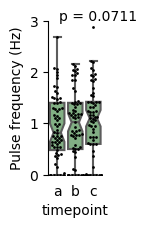

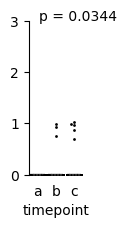

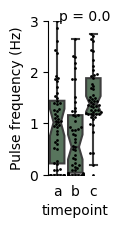

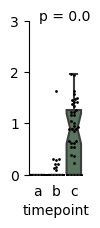

In [42]:
graph_fried(aligned_fried,colour='#7AB77D',save="boxplots_nosocstim_rolling")
graph_fried(bligned_fried,colour='#537A5A',save="boxplots_withsocstim_rolling")

### Cumulative distribution

In [144]:
def cum_dist_pulses(data):
    cumsum = data.query("Time_loom > 0")
    cumsum_piv = cumsum.pivot(columns="concat_filestim",index = "Loom_time",values = 'measured_pulsing') 
    ns = cumsum_piv.sum(axis = 1)
    ns = pd.DataFrame(ns,columns=["Ns"])
    ns.reset_index(inplace = True)
    fig,ax = plt.subplots(figsize=([8,4]))
    plt.plot(ns.Loom_time,ns.Ns)
    cumsum = cumsum.sort_values(by = ["Time_loom"])
    cumsum = cumsum.dropna(subset=["pulse"])
    cumsum_pulse = cumsum.query("pulse == 1")
    merged = cumsum_pulse.merge(ns,how='left',on='Loom_time')
    merged["pulse_weight"] = 1/merged["Ns"]
    merged["Pulse_cumul"] = merged.pulse_weight.cumsum()
    return merged

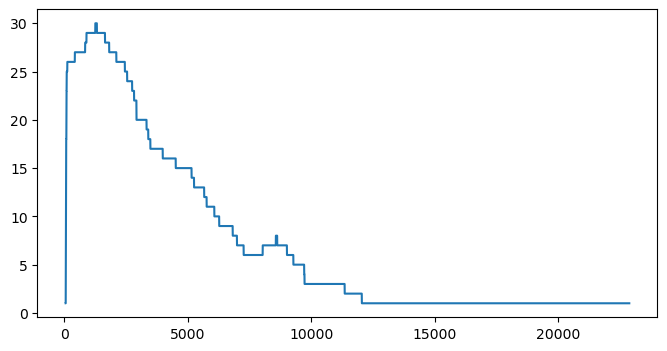

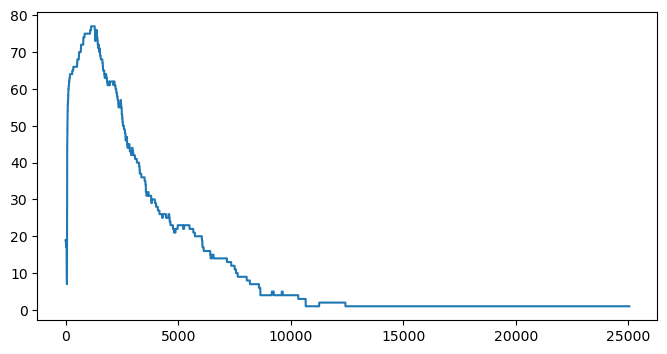

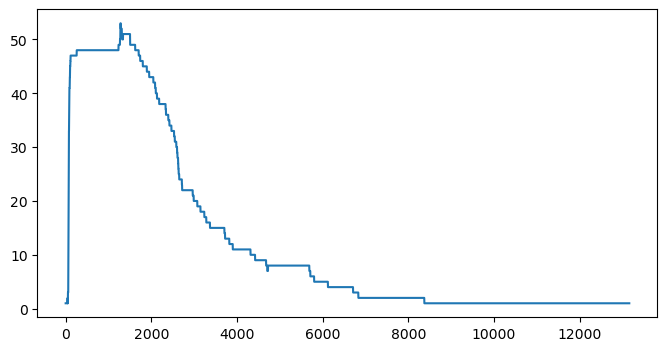

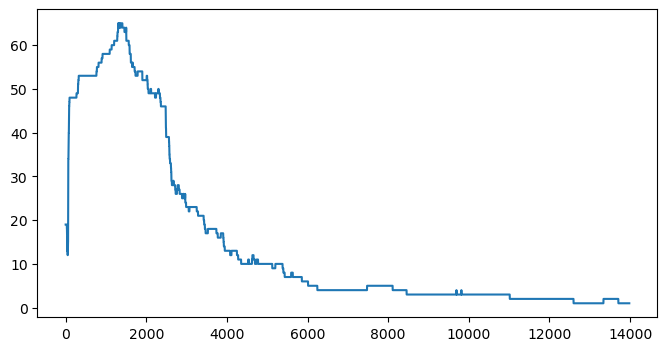

In [148]:
cumu_sum_aligned_Q = cum_dist_pulses(data_aligned_all.query("pulse_type == 'Quiescent'"))
cumu_sum_aligned_P = cum_dist_pulses(data_aligned_all.query("pulse_type == 'Pulsing'"))
cumu_sum_bligned_Q = cum_dist_pulses(data_b_ligned_all.query("pulse_type == 'Quiescent'"))
cumu_sum_bligned_P = cum_dist_pulses(data_b_ligned_all.query("pulse_type == 'Pulsing'"))

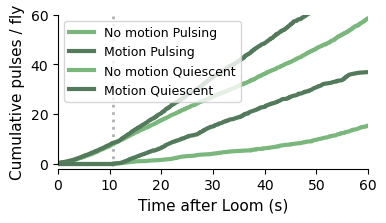

In [185]:
fig,ax = plt.subplots(figsize=([4,2]))
plt.vlines(stim_len,-1,60,linestyle=":",linewidth = 2,color='k',alpha=0.3)
plt.plot(cumu_sum_aligned_P.Time_loom,cumu_sum_aligned_P.Pulse_cumul,c='#7AB77D',linewidth = 3,label = "No motion Pulsing")
plt.plot(cumu_sum_bligned_P.Time_loom,cumu_sum_bligned_P.Pulse_cumul,c='#537A5A',linewidth = 3,label = "Motion Pulsing")
plt.plot(cumu_sum_aligned_Q.Time_loom,cumu_sum_aligned_Q.Pulse_cumul,c='#7AB77D',linewidth = 3,label = "No motion Quiescent")
plt.plot(cumu_sum_bligned_Q.Time_loom,cumu_sum_bligned_Q.Pulse_cumul,c='#537A5A',linewidth = 3,label = "Motion Quiescent")
plt.hlines(0,0,stim_len-0.1,color='#7AB77D',linewidth = 3)
plt.hlines(0,0,stim_len-0.1,color='#537A5A',linewidth = 3)

plt.xlim([0,60])
plt.ylim([-2,60])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_bounds(0,60)
plt.legend(fontsize = 9)
plt.xlabel("Time after Loom (s)",fontsize = 11)
plt.ylabel("Cumulative pulses / fly",fontsize = 11)
fig.savefig(save_location+"_cumulative_pulses.svg")

### Freezing over time whole experiment

In [ ]:
def freezing_over_time(data,bins = 0.05,graph='no'):
    meanz_all = pd.DataFrame()
    bin_size = int(frame_rate_pg*bins)
    end_frame = bin_size/600
    #print(end_frame)
    time = np.arange(0,1000,bins).round(2)
    for name in data.Filename.unique():
        dataz1 = data.query("Filename == @name")
        no_bins = int(dataz1.shape[0]//bin_size)
        dataz = dataz1.iloc[:no_bins*bin_size]
        #print(dataz.shape)
        dat_resh = np.array(dataz.immobility).reshape([no_bins,bin_size])
        #print(dat_resh.shape)
        meanz = pd.DataFrame({"Immobility":dat_resh.mean(axis=1)})
        #print(meanz.shape)
        meanz["Filename"] = name
        meanz["Time"] = time[:meanz.shape[0]]
        #print(meanz)
        #sem = pd.Series(dat_resh.sem(axis=1))
        #print(meanz)
        meanz_all = pd.concat([meanz_all,meanz])
    #print(meanz_all)
    if graph == 'yes':
        fig,ax1 = plt.subplots(figsize=(4,3)) #NB very slow but it does eventually run
        sns.lineplot(data=meanz_all,x='Time',y='Immobility',c='k')
        plt.xlim(-10,600)
        ax1.spines['bottom'].set_bounds(0,600) 
        ax1.spines['left'].set_bounds(0,1) 
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        fig.savefig(save_location+"proportion_of_freezing_autoloom_bin"+str(bins)+".svg")

    
    #        c='k')
    return(meanz_all)

means_aligned = freezing_over_time(data_aligned_all,bins=0.2,graph='no')
means_bligned = freezing_over_time(data_b_ligned_all,bins=0.2,graph='no')

#supp figure 1
fig,ax1 = plt.subplots(figsize=(4,3)) #NB very slow but it does eventually run
sns.lineplot(data=means_bligned,x='Time',y='Immobility',c='#537A5A')   
sns.lineplot(data=means_aligned,x='Time',y='Immobility',c='#7AB77D')
        
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
#ax1.spines['left'].set_bounds(0,len(evz_tot))
ax1.spines['bottom'].set_bounds(0,600) 
ax1.spines['left'].set_bounds(0,1) 
plt.xticks(fontsize = 9)
plt.ylim([-0.05,1])
plt.xlim([-10,600])
plt.yticks(fontsize = 9)
plt.xlabel("Time (s)",fontsize = 11)
plt.ylabel("Proportion of flies freezing",fontsize = 11)

### Conjunto graphs

In [ ]:
def conjunto_graphs(data_stim_pulses1,freq_all1,data_stim_pulses2,freq_all2,data1,data2,colour1,colour2):
    #pal = 'Set1'
    
    pal = sns.color_palette([colour1,colour2])
    
    frq_bout_all = pd.concat([freq_all1,freq_all2])
    frq_bout_all.reset_index(inplace=True)
    
    #freq_all1.to_csv(save_location+"freq_aligned.csv")
    #freq_all2.to_csv(save_location+"freq_b_ligned.csv")
    
    
    fig,ax = plt.subplots(figsize=([4,3]))
    sns.violinplot(data=frq_bout_all.query("Loom == 'yes'"),x="Condition",y="pre_stim_freq",fliersize=0,linewidth=1,cut=0,inner='quart',palette=pal)
    sns.swarmplot(data=frq_bout_all.query("Loom == 'yes'"),x="Condition",y="pre_stim_freq",c='k',size=3)
    plt.ylim([0,3])
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 11)
    plt.ylabel("Pulse Frequency before the stim (Hz)",fontsize = 13)
    plt.xlabel("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['left'].set_bounds(0,3.2)
    plt.tick_params(axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,rotation=45)
    for l in ax.lines:
        l.set_linewidth(0.75)
        l.set_linestyle('solid')
    for l in ax.lines[1::3]:
        l.set_linewidth(4)
    ax.spines['bottom'].set_visible(False)
    
    p_sep = sp.posthoc_dunn(frq_bout_all.query("pre_stim_freq>=0"),val_col = 'pre_stim_freq',group_col="Condition", p_adjust = 'bonferroni')
    plt.text(0.3,2.5,"p = "+str(p_sep.iloc[0,1].round(3)),fontsize=13)
    
    
    fig,ax = plt.subplots(figsize=([6,4]))
    sns.violinplot(data=frq_bout_all.query("Loom == 'yes'"),x="Condition",y="post_stim_time",fliersize=0,linewidth=1,cut=0,inner='quart',palette=pal)
    sns.swarmplot(data=frq_bout_all.query("Loom == 'yes'"),x="Condition",y="post_stim_time",c='k',size=3)
    plt.ylim([0,100])
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 11)
    plt.ylabel("Freeze length after stim onset (s)",fontsize = 13)
    plt.xlabel("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['left'].set_bounds(0,3.2)
    plt.tick_params(axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,rotation=45)
    for l in ax.lines:
        l.set_linewidth(0.75)
        l.set_linestyle('solid')
    for l in ax.lines[1::3]:
        l.set_linewidth(4)
    #ax1.spines['left'].set_bounds(0,len(evz_tot))
    ax.spines['bottom'].set_visible(False)

    p_sep = sp.posthoc_dunn(frq_bout_all.query("post_stim_time>=0"),val_col = 'post_stim_time',group_col="Condition", p_adjust = 'bonferroni')
    plt.text(0.3,80,"p = "+str(p_sep.iloc[0,1].round(5)),fontsize=13)
    
    
    fig,ax = plt.subplots(figsize=([6,4]))
    sns.violinplot(data=frq_bout_all.query("Loom == 'yes'"),x="Condition",y="post_stim_freq",fliersize=0,linewidth=1,cut=0,inner='quart',palette=pal)
    sns.swarmplot(data=frq_bout_all.query("Loom == 'yes'"),x="Condition",y="post_stim_freq",c='k',size=3)
    plt.ylim([0,4.2])
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 11)
    plt.ylabel("Pulse Frequency after stim onset (Hz)",fontsize = 12)
    plt.xlabel("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['left'].set_bounds(0,3.2)
    plt.tick_params(axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,rotation=45)
    for l in ax.lines:
        l.set_linewidth(0.75)
        l.set_linestyle('solid')
    for l in ax.lines[1::3]:
        l.set_linewidth(4)
    #ax1.spines['left'].set_bounds(0,len(evz_tot))
    ax.spines['bottom'].set_visible(False)
    
    p_sep = sp.posthoc_dunn(frq_bout_all.query("post_stim_freq>=0"),val_col = 'post_stim_freq',group_col="Condition", p_adjust = 'bonferroni')
    plt.text(0.3,3.5,"p = "+str(p_sep.iloc[0,1].round(5)),fontsize=13)
    
    
    lw = 2
    aligned_piv = pd.pivot(data_stim_pulses1,index="bin_centre",columns="file_clip",values='pulse')
    b_ligned_piv = pd.pivot(data_stim_pulses2,index="bin_centre",columns="file_clip",values='pulse')
    
    #aligned_piv.to_csv(save_location+"aligned_piv.csv")
    #b_ligned_piv.to_csv(save_location+"b_ligned_piv.csv")
    
    fig, ax = plt.subplots(figsize=(6,3))
    plt.vlines(stim_len,0,3,color=[0.5,0.5,0.5],linestyle=':',linewidth=lw)
    plt.step(aligned_piv.index,aligned_piv.mean(axis=1),linewidth=lw,color=colour1,where='mid',label="No Motion Cue")
    plt.vlines(aligned_piv.index,aligned_piv.mean(axis=1)-aligned_piv.sem(axis=1),aligned_piv.mean(axis=1)+aligned_piv.sem(axis=1),linewidth=2,color=colour1,alpha=0.5)
    plt.step(b_ligned_piv.index,b_ligned_piv.mean(axis=1),linewidth=lw,color=colour2,where='mid',label='With Motion Cue')
    plt.vlines(b_ligned_piv.index,b_ligned_piv.mean(axis=1)-b_ligned_piv.sem(axis=1),b_ligned_piv.mean(axis=1)+b_ligned_piv.sem(axis=1),linewidth=2,color=colour2,alpha=0.5)
    plt.legend("")
    plt.ylabel("Pulse frequency (Hz)",fontsize = 11)
    plt.xlabel("Time from Loom (s)",fontsize = 11)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.xlim([0,40])
    plt.ylim([0,2.5])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_bounds(0,2.5)
    #ax1.spines['left'].set_bounds(0,len(evz_tot))
    ax.spines['bottom'].set_bounds(0,40)
    ax.legend(frameon = False,loc='upper left',fontsize = 8)
    #plt.savefig(save_location+"freq_over_time.svg",bbox_inches='tight')
    
    fig, ax = plt.subplots(figsize=(6,3))
    plt.vlines(stim_len,0,3,color=[0.5,0.5,0.5],linestyle=':',linewidth=lw)
    plt.step(aligned_piv.index,aligned_piv.median(axis=1),linewidth=lw,color=colour1,where='mid',label="No Motion Cue")
    plt.vlines(aligned_piv.index,aligned_piv.median(axis=1)-aligned_piv.sem(axis=1),aligned_piv.median(axis=1)+aligned_piv.sem(axis=1),linewidth=2,color=colour1,alpha=0.5)
    plt.step(b_ligned_piv.index,b_ligned_piv.median(axis=1),linewidth=lw,color=colour2,where='mid',label='With Motion Cue')
    plt.vlines(b_ligned_piv.index,b_ligned_piv.median(axis=1)-b_ligned_piv.sem(axis=1),b_ligned_piv.median(axis=1)+b_ligned_piv.sem(axis=1),linewidth=2,color=colour2,alpha=0.5)
    plt.legend("")
    plt.ylabel("Pulse frequency median(Hz)",fontsize = 11)
    plt.xlabel("Time from Loom (s)",fontsize = 11)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.xlim([0,40])
    plt.ylim([0,2.5])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_bounds(0,2.5)
    #ax1.spines['left'].set_bounds(0,len(evz_tot))
    ax.spines['bottom'].set_bounds(0,40)
    ax.legend(frameon = False,loc='upper left',fontsize = 8)
    #plt.savefig(save_location+"freq_over_time.svg",bbox_inches='tight')
    
    #fig,ax1 = plt.subplots(figsize=(3.5,3))
    #sns.lineplot(data=aligned_piv,x=index,y="freq",color = 'b',label="Baseline")
    #sns.lineplot(data=b_ligned_piv,x=index,y="freq",color = 'r',label="Stimulation")
    #limx = -60
    #ax1.set_xlim([limx,1])
    #ax1.set_ylim([-0.1,2.4])
    #ax1.spines['right'].set_visible(False)
    #ax1.spines['top'].set_visible(False)
    #ax1.spines['bottom'].set_bounds(limx,1)
    #ax1.spines['left'].set_bounds(0,2.2)
    #plt.xlabel("Time to movement onset (s)",fontsize = 11)
    #plt.ylabel("Pulse frequency (Hz)",fontsize = 11)
    #plt.xticks(fontsize = 9)
    #plt.yticks(fontsize = 9)
    #plt.legend(fontsize = 11,loc=(0.05,0.8),frameon=False)
    ##fig.savefig(save1+"_frequency_over_time.svg")
    
    
    
    fig, ax = plt.subplots(figsize=(6,3))
    plt.vlines(10,0,3,color=[0.5,0.5,0.5],linestyle=':',linewidth=lw)
    plt.step(aligned_piv.index,aligned_piv.count(axis=1),linewidth=lw,color=colour1,where='mid',label="No Motion Cue")
    #plt.vlines(aligned_piv.index,aligned_piv.count(axis=1)-aligned_piv.sem(axis=1),aligned_piv.mean(axis=1)+aligned_piv.sem(axis=1),linewidth=2,color='Crimson',alpha=0.5)
    plt.step(b_ligned_piv.index,b_ligned_piv.count(axis=1),linewidth=lw,color=colour2,where='mid',label='With Motion Cue')
    #plt.vlines(b_ligned_piv.index,b_ligned_piv.count(axis=1)-b_ligned_piv.sem(axis=1),b_ligned_piv.mean(axis=1)+b_ligned_piv.sem(axis=1),linewidth=2,color='steelblue',alpha=0.5)
    plt.legend("")
    plt.ylabel("Number of data points",fontsize = 11)
    plt.xlabel("Time from Loom (s)",fontsize = 11)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.xlim([0,40])
    #plt.ylim([0,2.5])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_bounds(0,2.5)
    #ax1.spines['left'].set_bounds(0,len(evz_tot))
    ax.spines['bottom'].set_bounds(0,40)
    ax.legend(frameon = False,loc='upper right',fontsize = 8)
    #plt.savefig(save_location+"freq_over_time.svg",bbox_inches='tight')
    
    
    daz = data1.reset_index() #aligned - no motion cue
    daz2 = data2.reset_index() #b-ligned - with motion cue
    
    fig,ax = plt.subplots(figsize=([8,4]))
    plt.vlines(stim_len,0,0.04,linewidth = 5,color = [0.7,0.7,0.7],linestyle = "--")
    sns.lineplot(daz.query("Stim_time_hc > 0.6 and Stim_time_hc < 20 "),x="Stim_time_hc",y="pulse_convolved",label="No Motion Cue",color=colour1)
    sns.lineplot(daz2.query("Stim_time_hc > 0.6 and Stim_time_hc < 20"),x="Stim_time_hc",y="pulse_convolved",label="With Motion Cue",color=colour2)
    
    
    plt.ylabel("Pulse frequency (AU)",fontsize = 11)
    plt.xlabel("Time from Loom (s)",fontsize = 11)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(frameon = False,loc='upper left',fontsize = 8)
    
    
    fig,ax = plt.subplots(figsize=([6,4]))
    sns.regplot(data=frq_bout_all.query("Loom == 'yes' and Condition == 'No Motion Cue'"),x="pause_length",y="tot_freq",color=colour1)#,hue="Condition",palette=pal)#,fliersize=0,linewidth=1,cut=0,inner='quart',palette=pal)
    sns.regplot(data=frq_bout_all.query("Loom == 'yes' and Condition == 'With Motion Cue'"),x="pause_length",y="tot_freq",color=colour2)
    #sns.swarmplot(data=frq_bout_all_c.query("Loom == 'yes'"),x="Condition",y="post_stim_freq",c='k',size=3)
    plt.ylim([0,3.5])
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 11)
    plt.ylabel("Total pulse frequency",fontsize = 13)
    plt.xlabel("Pause length (s)",fontsize = 13)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['left'].set_bounds(0,3.2)
    plt.tick_params(axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,rotation=45)
    slope, intercept, r, p, se = stats.linregress(frq_bout_all.query("Loom == 'yes' and Condition == 'No Motion Cue'").tot_freq, frq_bout_all.query("Loom == 'yes' and Condition == 'No Motion Cue'").pause_length)
    plt.text(0.3,3.5,"p No mot = "+str(p.round(3)),color = colour1)
    slope, intercept, r, p, se = stats.linregress(frq_bout_all.query("Loom == 'yes' and Condition == 'With Motion Cue'").tot_freq, frq_bout_all.query("Loom == 'yes' and Condition == 'With Motion Cue'").pause_length)
    plt.text(0.3,3,"p With mot = "+str(p.round(3)),color = colour2)
    #print("P9 Low")
    #print(slope,intercept,r,p)
    
    colors = [(1, 0, 0), (1, 0.4, 0.4),(0.2, 0.2, 1),
          (0.5, 0.5, 1)]

    my_map = sns.color_palette(colors)
    
    #orderz=['Pulsing_Aligned','Quiescent_Aligned','Pulsing_B-ligned','Quiescent_B-ligned']
    orderz=['Pulsing_No Motion Cue','Quiescent_No Motion Cue','Pulsing_With Motion Cue','Quiescent_With Motion Cue']
    
    fig,ax = plt.subplots(figsize=([6,4]))
    sns.violinplot(data=frq_bout_all.query("Loom == 'yes'"),x="pulse_condition",y="post_stim_time",fliersize=0,scale='count',linewidth=1,cut=0,inner='quart',palette=my_map,order=orderz)
    sns.swarmplot(data=frq_bout_all.query("Loom == 'yes'"),x="pulse_condition",y="post_stim_time",c='k',size=4,order=orderz)
    plt.ylim([0,100])
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 11)
    plt.ylabel("Time spent freezing after stim",fontsize = 13)
    plt.xlabel("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tick_params(axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,rotation=45)
    
    for l in ax.lines:
        l.set_linewidth(1)
        l.set_linestyle('solid')
    for l in ax.lines[1::3]:
        l.set_linewidth(2)
    for l in ax.lines:
        l.set_color('k')
        
    p_sep = sp.posthoc_dunn(frq_bout_all.query("Loom == 'yes' and pulse_type == 'Quiescent'"),val_col = 'post_stim_time',group_col="pulse_condition", p_adjust = 'bonferroni')
    #print(p_sep)
    plt.text(4,20,"p Quiescent = "+str(p_sep.iloc[0,1].round(5)),fontsize=13)
    
    p_sep = sp.posthoc_dunn(frq_bout_all.query("Loom == 'yes' and pulse_type == 'Pulsing'"),val_col = 'post_stim_time',group_col="pulse_condition", p_adjust = 'bonferroni')
    #print(p_sep)
    plt.text(4,40,"p Pulsing = "+str(p_sep.iloc[0,1].round(5)),fontsize=13)
    
    
    fig,ax = plt.subplots(figsize=([6,4]))
    sns.violinplot(data=frq_bout_all.query("Loom == 'yes'"),x="pulse_condition",y="first_pulse_delay",fliersize=0,scale='count',linewidth=1,cut=0,inner='quart',palette=my_map,order=orderz)
    sns.swarmplot(data=frq_bout_all.query("Loom == 'yes'"),x="pulse_condition",y="first_pulse_delay",c='k',size=4,order=orderz)
    plt.ylim([0,91])
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 11)
    plt.ylabel("Delay to first pulse",fontsize = 13)
    plt.xlabel("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tick_params(axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,rotation=45)
    
    for l in ax.lines:
        l.set_linewidth(1)
        l.set_linestyle('solid')
    for l in ax.lines[1::3]:
        l.set_linewidth(2)
    for l in ax.lines:
        l.set_color('k')
        
    p_sep = sp.posthoc_dunn(frq_bout_all.query("Loom == 'yes' and pulse_type == 'Quiescent'"),val_col = 'first_pulse_delay',group_col="pulse_condition", p_adjust = 'bonferroni')
    #print(p_sep)
    plt.text(4,20,"p Quiescent = "+str(p_sep.iloc[0,1].round(5)),fontsize=13)
    
    p_sep = sp.posthoc_dunn(frq_bout_all.query("Loom == 'yes' and pulse_type == 'Pulsing'"),val_col = 'first_pulse_delay',group_col="pulse_condition", p_adjust = 'bonferroni')
    #print(p_sep)
    plt.text(4,40,"p Pulsing = "+str(p_sep.iloc[0,1].round(5)),fontsize=13)  
    
    
    fig,ax = plt.subplots(figsize=([6,4]))
    sns.violinplot(data=frq_bout_all.query("Loom == 'yes'"),x="pulse_condition",y="lag",fliersize=0,scale='count',linewidth=1,cut=0,inner='quart',palette=my_map,order=orderz)
    sns.swarmplot(data=frq_bout_all.query("Loom == 'yes'"),x="pulse_condition",y="lag",c='k',size=2,order=orderz)
    #plt.ylim([0,91])
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 11)
    plt.ylabel("Lag to enter freezing",fontsize = 13)
    plt.xlabel("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tick_params(axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,rotation=45)
    
    for l in ax.lines:
        l.set_linewidth(1)
        l.set_linestyle('solid')
    for l in ax.lines[1::3]:
        l.set_linewidth(2)
    for l in ax.lines:
        l.set_color('k')
        
    p_sep = sp.posthoc_dunn(frq_bout_all.query("Loom == 'yes' and pulse_type == 'Quiescent'"),val_col = 'lag',group_col="pulse_condition", p_adjust = 'bonferroni')
    #print(p_sep)
    plt.text(4,2,"p Quiescent = "+str(p_sep.iloc[0,1].round(5)),fontsize=13)
    
    p_sep = sp.posthoc_dunn(frq_bout_all.query("Loom == 'yes' and pulse_type == 'Pulsing'"),val_col = 'lag',group_col="pulse_condition", p_adjust = 'bonferroni')
    #print(p_sep)
    plt.text(4,4,"p Pulsing = "+str(p_sep.iloc[0,1].round(5)),fontsize=13)  
    
    
    
    
    fig,ax = plt.subplots(figsize=([6,6]))
    sns.regplot(data=freq_all2.query("Loom == 'yes'"),x='post_stim_time',y='post_stim_freq')
    
    


## Smoothed pulse

In [ ]:
daz = data_b_ligned_all.reset_index()
daz2 = data_aligned_all.reset_index()

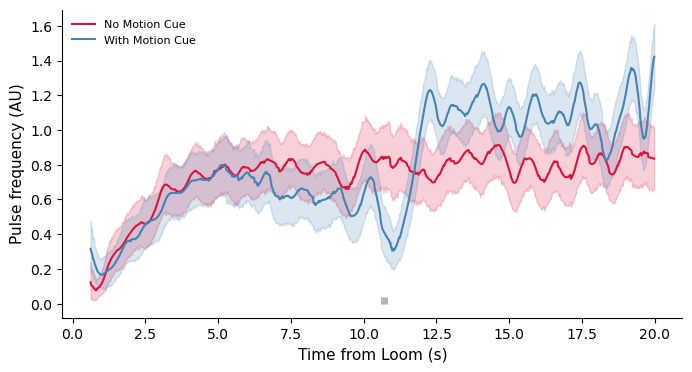

In [33]:


fig,ax = plt.subplots(figsize=([8,4]))
plt.vlines(stim_len,0,0.04,linewidth = 5,color = [0.7,0.7,0.7],linestyle = "--")
sns.lineplot(daz2.query("Stim_time_hc > 0.6 and Stim_time_hc < 20"),x="Stim_time_hc",y="pulse_convolved",label="No Motion Cue",color='crimson')
sns.lineplot(daz.query("Stim_time_hc > 0.6 and Stim_time_hc < 20 "),x="Stim_time_hc",y="pulse_convolved",label="With Motion Cue",color='steelblue')

plt.ylabel("Pulse frequency (AU)",fontsize = 11)
plt.xlabel("Time from Loom (s)",fontsize = 11)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
#plt.xlim([0,40])
#plt.ylim([0,2.5])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['left'].set_bounds(0,2.5)
#ax1.spines['left'].set_bounds(0,len(evz_tot))
#ax.spines['bottom'].set_bounds(0,40)
ax.legend(frameon = False,loc='upper left',fontsize = 8)


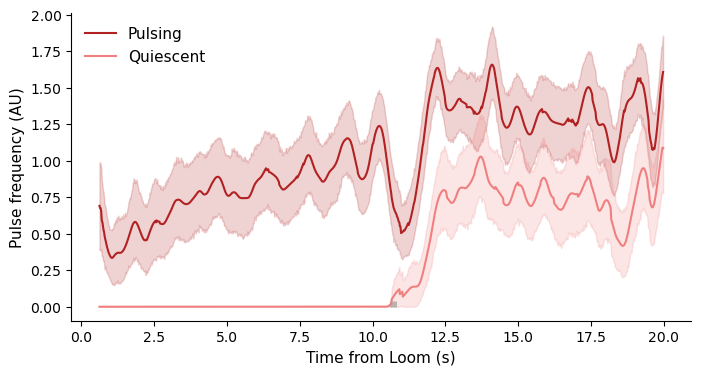

In [34]:
fig,ax = plt.subplots(figsize=([8,4]))
plt.vlines(stim_len,0,0.04,linewidth = 5,color = [0.7,0.7,0.7],linestyle = "--")
sns.lineplot(daz.query("Stim_time_hc > 0.6 and Stim_time_hc < 20 and pulse_type == 'Pulsing'"),x="Stim_time_hc",y="pulse_convolved",label="Pulsing",color='firebrick')
sns.lineplot(daz.query("Stim_time_hc > 0.6 and Stim_time_hc < 20 and pulse_type == 'Quiescent'"),x="Stim_time_hc",y="pulse_convolved",label="Quiescent",color='lightcoral')

plt.ylabel("Pulse frequency (AU)",fontsize = 11)
plt.xlabel("Time from Loom (s)",fontsize = 11)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
#plt.xlim([0,40])
#plt.ylim([0,2.5])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['left'].set_bounds(0,2.5)
#ax1.spines['left'].set_bounds(0,len(evz_tot))
#ax.spines['bottom'].set_bounds(0,40)
ax.legend(frameon = False,loc='upper left',fontsize = 11)


### IS THIS RIGHT?? THE LINES SEEM TOO ALIGNED...

In [ ]:
fig,ax = plt.subplots(figsize=([8,4]))
plt.vlines(stim_len,0,0.04,linewidth = 5,color = [0.7,0.7,0.7],linestyle = "--")
sns.lineplot(daz.query("Stim_time_hc > 0.6 and Stim_time_hc < 20 and pulse_type == 'Pulsing'"),x="Stim_time_hc",y="pulse_convolved",label="Pulsing",color='firebrick')
sns.lineplot(daz.query("Stim_time_hc > 0.6 and Stim_time_hc < 20 and pulse_type == 'Quiescent'"),x="Stim_time_hc",y="pulse_convolved",label="Quiescent",color='lightcoral')

plt.ylabel("Pulse frequency (AU)",fontsize = 11)
plt.xlabel("Time from Loom (s)",fontsize = 11)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
#plt.xlim([0,40])
#plt.ylim([0,2.5])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['left'].set_bounds(0,2.5)
#ax1.spines['left'].set_bounds(0,len(evz_tot))
#ax.spines['bottom'].set_bounds(0,40)
ax.legend(frameon = False,loc='upper left',fontsize = 11)

In [ ]:
#daz = data_b_ligned_all.reset_index()
#daz2 = data_aligned_all.reset_index()

fig,ax = plt.subplots(figsize=([8,4]))
plt.vlines(stim_len,0,0.04,linewidth = 5,color = [0.7,0.7,0.7],linestyle = "--")
sns.lineplot(daz2.query("Stim_time_hc > 0.6 and Stim_time_hc < 20"),x="Stim_time_hc",y="pulse_smoothed",label="No Motion Cue",color='crimson')
sns.lineplot(daz.query("Stim_time_hc > 0.6 and Stim_time_hc < 20 "),x="Stim_time_hc",y="pulse_smoothed",label="With Motion Cue",color='steelblue')

#plt.ylabel("Pulse frequency (AU)",fontsize = 11)
plt.xlabel("Time from Loom (s)",fontsize = 11)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
#plt.xlim([0,40])
#plt.ylim([0,2.5])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['left'].set_bounds(0,2.5)
#ax1.spines['left'].set_bounds(0,len(evz_tot))
#ax.spines['bottom'].set_bounds(0,40)
ax.legend(frameon = False,loc='upper left',fontsize = 8)

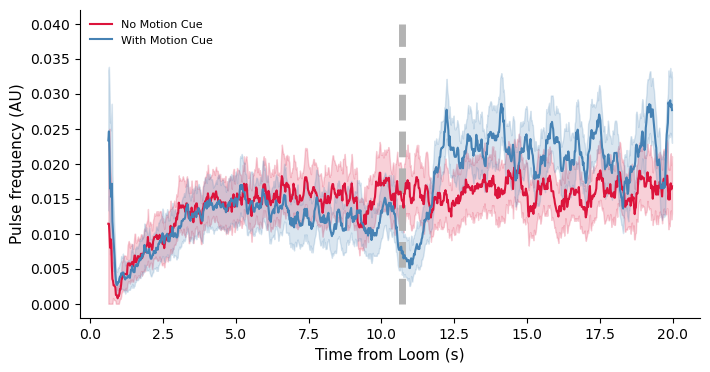

In [24]:
#daz = data_b_ligned_all.reset_index()
#daz2 = data_aligned_all.reset_index()


fig,ax = plt.subplots(figsize=([8,4]))
plt.vlines(stim_len,0,0.04,linewidth = 5,color = [0.7,0.7,0.7],linestyle = "--")
sns.lineplot(daz2.query("Stim_time_hc > 0.6 and Stim_time_hc < 20"),x="Stim_time_hc",y="pulse_smoothed",label="No Motion Cue",color='crimson')
sns.lineplot(daz.query("Stim_time_hc > 0.6 and Stim_time_hc < 20 "),x="Stim_time_hc",y="pulse_smoothed",label="With Motion Cue",color='steelblue')

#plt.ylabel("Pulse frequency (AU)",fontsize = 11)
plt.xlabel("Time from Loom (s)",fontsize = 11)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
#plt.xlim([0,40])
#plt.ylim([0,2.5])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['left'].set_bounds(0,2.5)
#ax1.spines['left'].set_bounds(0,len(evz_tot))
#ax.spines['bottom'].set_bounds(0,40)
ax.legend(frameon = False,loc='upper left',fontsize = 8)


In [29]:
daz['pulse_smoothed'] = daz['pulse_smoothed']*25
daz2['pulse_smoothed'] = daz2['pulse_smoothed']*25

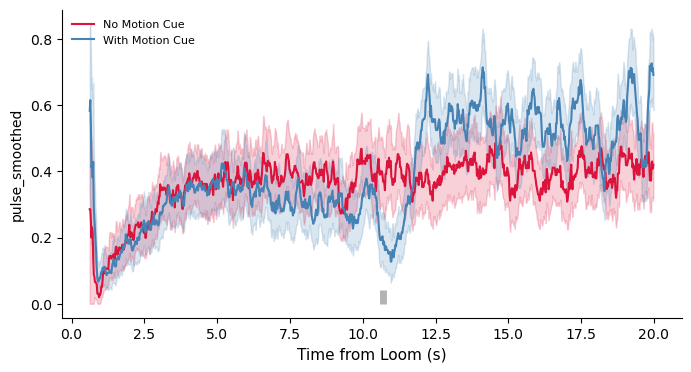

In [30]:
fig,ax = plt.subplots(figsize=([8,4]))
plt.vlines(stim_len,0,0.04,linewidth = 5,color = [0.7,0.7,0.7],linestyle = "--")
sns.lineplot(daz2.query("Stim_time_hc > 0.6 and Stim_time_hc < 20"),x="Stim_time_hc",y="pulse_smoothed",label="No Motion Cue",color='crimson')
sns.lineplot(daz.query("Stim_time_hc > 0.6 and Stim_time_hc < 20 "),x="Stim_time_hc",y="pulse_smoothed",label="With Motion Cue",color='steelblue')

#plt.ylabel("Pulse frequency (AU)",fontsize = 11)
plt.xlabel("Time from Loom (s)",fontsize = 11)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
#plt.xlim([0,40])
#plt.ylim([0,2.5])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['left'].set_bounds(0,2.5)
#ax1.spines['left'].set_bounds(0,len(evz_tot))
#ax.spines['bottom'].set_bounds(0,40)
ax.legend(frameon = False,loc='upper left',fontsize = 8)


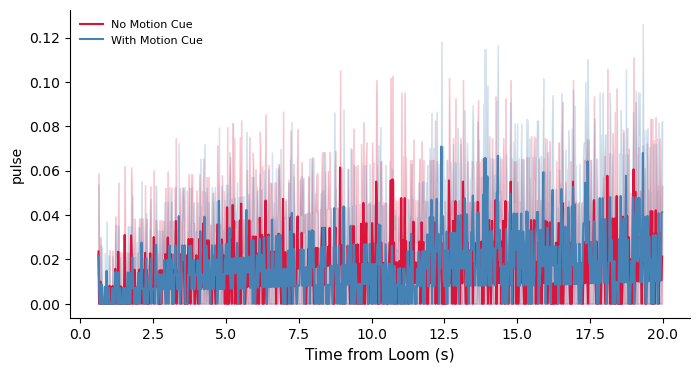

In [31]:
daz = data_b_ligned_all.reset_index()
daz2 = data_aligned_all.reset_index()

fig,ax = plt.subplots(figsize=([8,4]))
plt.vlines(stim_len,0,0.04,linewidth = 5,color = [0.7,0.7,0.7],linestyle = "--")
sns.lineplot(daz2.query("Stim_time_hc > 0.6 and Stim_time_hc < 20"),x="Stim_time_hc",y="pulse",label="No Motion Cue",color='crimson')
sns.lineplot(daz.query("Stim_time_hc > 0.6 and Stim_time_hc < 20 "),x="Stim_time_hc",y="pulse",label="With Motion Cue",color='steelblue')

#plt.ylabel("Pulse frequency (AU)",fontsize = 11)
plt.xlabel("Time from Loom (s)",fontsize = 11)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
#plt.xlim([0,40])
#plt.ylim([0,2.5])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['left'].set_bounds(0,2.5)
#ax1.spines['left'].set_bounds(0,len(evz_tot))
#ax.spines['bottom'].set_bounds(0,40)
ax.legend(frameon = False,loc='upper left',fontsize = 8)


In [ ]:
g = data_aligned_all.Filename.unique()[0:1]

win = signal.windows.hann(20)


datz = data_aligned_all.query("Filename == @file and Clip > 0")
for Clp in datz.Clip.unique():
    dazz = datz.query("Clip == @Clp")
    sig = np.array(dazz.pulse)
    #print(sig)
    filtered = signal.convolve(sig, win, mode='same') / sum(win)
    fig, (ax_orig, ax_win, ax_filt) = plt.subplots(3, 1, sharex=True)
    ax_orig.plot(sig)
    ax_orig.set_title('Original pulse')
    ax_orig.margins(0, 0.1)
    ax_win.plot(win)
    ax_win.set_title('Filter impulse response')
    ax_win.margins(0, 0.1)
    ax_filt.plot(filtered)
    ax_filt.set_title('Filtered signal')
    ax_filt.margins(0, 0.1)
    fig.tight_layout()
    fig.show()
    

In [ ]:
fig,ax = plt.subplots(figsize=([6,4]))
sns.swarmplot(data_b_ligned_all.query("event == 'Motion_signal'").Time_loom)
plt.ylim([10,11])
plt.hlines(10.5,-1,1,color='k',linestyle='--')
plt.ylabel("Time of motion cue onset (s)",fontsize = 13)

In [ ]:
fig,ax = plt.subplots(figsize=([6,4]))
sns.violinplot(data=frq_bout_all_c.query("Loom == 'yes'"),x="Condition",y="post_stim_time",hue="pulse_type",fliersize=0,linewidth=1,cut=0,inner='quart',order=["Aligned","B-ligned"])
#sns.swarmplot(data=frq_bout_all.query("Loom == 'yes'"),x="Condition",y="post_stim_freq",c='k',size=3)
#plt.ylim([0,100])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 11)
plt.ylabel("Time spent freezing after stim",fontsize = 13)
plt.xlabel("")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['left'].set_bounds(0,3.2)
plt.tick_params(axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,rotation=45)
#ax1.spines['left'].set_bounds(0,len(evz_tot))
ax.spines['bottom'].set_visible(False)


In [ ]:
for file in data_b_ligned_c.Filename.unique():
    print(file)
    stim_pulses_b_ligned_c_i,frq_all_clips_b_ligned_c_i = pulse_locations(data_b_ligned_c.query("Filename == @file"),'blue','B-ligned',
            bin_size=1,sort = 'length',xlim1 = 80,condition="B-ligned",align='stim',graph='yes')#,save1=save_location+"P9_Low_")#,
